# Projet 7 - Développez une preuve de concept

L’algorithme choisit pour ce projet est **EfficientNet**. Il existe plusieurs versions de ce modèle allant de B0 à B7. En vue du nombre de paramètres dans certaines des versions, celles testées dans ce projet seront les modèles B0 à B4.  

# Préparation

## Importation des librairies

In [1]:
# Import files from drive
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
import matplotlib.pyplot as plt
import numpy as np
import os
import time
import random
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.applications import EfficientNetB0, EfficientNetB1, EfficientNetB2, EfficientNetB3, EfficientNetB4, EfficientNetB5
from keras.models import Sequential
from keras.layers.core import Flatten, Dense, Dropout
from keras.layers import GlobalMaxPooling2D, GlobalAveragePooling2D, BatchNormalization
from keras.optimizers import SGD, Adam, Adagrad, RMSprop, Adadelta
from keras.applications.inception_v3 import InceptionV3
from keras.initializers import glorot_uniform, VarianceScaling


In [3]:
# Check if GPU is enabled
# If so, it will print '/device:GPU:0'
import tensorflow as tf
tf.test.gpu_device_name()
print(tf.__version__)

2.4.1


In [4]:
os.getcwd()

'/content'

## Importation et séparation des données

Données train split en train et test

In [5]:
def image_datagen_load():
    datagen = ImageDataGenerator(rescale=1/255, validation_split=0.2 )

    train_datagen = datagen.flow_from_directory(
                    '/content/gdrive/MyDrive/Colab_Notebooks/Stanford_dog/train',
                    subset='training', seed = 3)

    test_datagen = datagen.flow_from_directory(
                    '/content/gdrive/MyDrive/Colab_Notebooks/Stanford_dog/train',
                    subset='validation', seed = 3)
    
    return train_datagen, test_datagen

In [6]:
train_datagen, test_datagen = image_datagen_load()

Found 9609 images belonging to 120 classes.
Found 2401 images belonging to 120 classes.


Données test: utilisées uniquement pour valider modèles finaux

In [7]:
datagen_test_final = ImageDataGenerator(rescale = 1/255)
test_datagen_final = datagen_test_final.flow_from_directory(
    '/content/gdrive/MyDrive/Colab_Notebooks/Stanford_dog/test')

Found 8589 images belonging to 120 classes.


In [8]:
# Move to directory Projet-6
%cd /content/gdrive/MyDrive/Colab_Notebooks/Stanford_dog/

/content/gdrive/MyDrive/Colab_Notebooks/Stanford_dog


In [ ]:
# Prepare data train et test with 5 classes without augmentation
def split_datagen_export():
    datagen = ImageDataGenerator(rescale=1/255, validation_split=0.2 )

    X_train = datagen.flow_from_directory(
                    '/content/gdrive/MyDrive/Colab_Notebooks/Stanford_dog/to_export',
                    subset='training', seed = 2)

    X_test = datagen.flow_from_directory(
                    '/content/gdrive/MyDrive/Colab_Notebooks/Stanford_dog/to_export',
                    subset='validation', seed = 2)
    
    return X_train, X_test

In [ ]:
X5_train, X5_test = split_datagen_export()

Found 400 images belonging to 5 classes.
Found 100 images belonging to 5 classes.


## Définition des callbacks

In [9]:
# Add callbacks
# Create paths 
#log_path = os.path.join(os.getcwd(), 'logs')
name_checkpoint = 'CP-saved-{}'.format(int(time.time()))
CP_path = 'saved_models/{}.h5'.format(name_checkpoint)

# Initialize callbacks
#tensorboard_callback = TensorBoard(log_dir = 'logs/{}'.format(name_logs), histogram_freq=1)
#checkpoint_cb = ModelCheckpoint(CP_path, save_best_only=True)
checkpoint_cb_best = ModelCheckpoint('saved_models/best_effnet_{}.h5'.format(int(time.time()), save_best_only=True))
early_stopping_cd = EarlyStopping(monitor = 'val_accuracy', patience=15)
reducelr = ReduceLROnPlateau(monitor='val_accuracy',
                             factor=np.sqrt(.1),
                             patience=8,
                             verbose=1,
                             mode='auto',
                             min_delta=.0001,
                             cooldown=0,
                             min_lr=0.0000001)

## Définition des fonctions

In [10]:
def show_history(history_name):
  # summarize history for accuracy
  plt.plot(history_name.history['accuracy'], 'c-')
  plt.plot(history_name.history['val_accuracy'], 'b-')
  plt.title('model accuracy')
  plt.ylabel('accuracy')
  plt.xlabel('epoch')
  plt.legend(['train', 'valid'], loc='upper left')
  plt.show()

  # summarize history for loss
  plt.plot(history_name.history['loss'], 'c-')
  plt.plot(history_name.history['val_loss'], 'b-')
  plt.title('model loss')
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.legend(['train', 'valid'], loc='upper left')
  plt.show()

# Modèle baseline - InceptionV3

In [ ]:
# load model without last layer
model_IV3 = InceptionV3(include_top=False, input_shape= (256,256,3), weights= 'imagenet')

# Set up the layers to not trainable
for layer in model_IV3.layers:
   layer.trainable = False

# summarize the model
model_IV3.summary()

# Add last layers
avg = GlobalAveragePooling2D()(model_IV3.output)
output = Dense(120, activation = 'softmax')(avg)
new_iv3 = tf.keras.Model(inputs = model_IV3.input, outputs = output)

87916544/87910968 [==============================] - 0s 0us/step
Model: "inception_v3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 127, 127, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 127, 127, 32) 96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 127, 127, 32) 0           batch_normalization[0][0]        
______________________

In [ ]:
batch_size=40
# Compile model 
new_iv3.compile(loss="categorical_crossentropy", 
                optimizer=Adam(learning_rate=0.0001), 
                metrics=["accuracy"])

# Fit model on generator (5 classes)
start = time.time()
history_iv3 = new_iv3.fit(train_datagen, validation_data=test_datagen, 
                                   epochs=40, verbose=2, 
                                   #callbacks = [checkpoint_cb, early_stopping_cd],
                                   steps_per_epoch=np.ceil(400/batch_size), 
                                   validation_steps=np.ceil(100/batch_size))

print('Execution time: ', time.time() - start)

Epoch 1/40
10/10 - 156s - loss: 4.9758 - accuracy: 0.0094 - val_loss: 4.7657 - val_accuracy: 0.0208
Epoch 2/40
10/10 - 123s - loss: 4.7833 - accuracy: 0.0188 - val_loss: 4.6639 - val_accuracy: 0.0104
Epoch 3/40
10/10 - 119s - loss: 4.6619 - accuracy: 0.0250 - val_loss: 4.6326 - val_accuracy: 0.0312
Epoch 4/40
10/10 - 103s - loss: 4.4969 - accuracy: 0.0594 - val_loss: 4.3441 - val_accuracy: 0.0938
Epoch 5/40
10/10 - 99s - loss: 4.3465 - accuracy: 0.0688 - val_loss: 4.1351 - val_accuracy: 0.1667
Epoch 6/40
10/10 - 101s - loss: 4.1692 - accuracy: 0.1187 - val_loss: 4.1264 - val_accuracy: 0.1146
Epoch 7/40
10/10 - 89s - loss: 3.9750 - accuracy: 0.1813 - val_loss: 4.0170 - val_accuracy: 0.2188
Epoch 8/40
10/10 - 87s - loss: 3.9338 - accuracy: 0.2250 - val_loss: 3.9325 - val_accuracy: 0.1562
Epoch 9/40
10/10 - 89s - loss: 3.8173 - accuracy: 0.2562 - val_loss: 3.6978 - val_accuracy: 0.2292
Epoch 10/40
10/10 - 75s - loss: 3.6420 - accuracy: 0.3219 - val_loss: 3.5060 - val_accuracy: 0.3333
Epoc

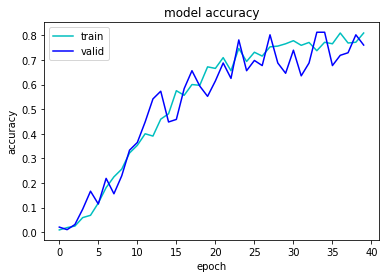

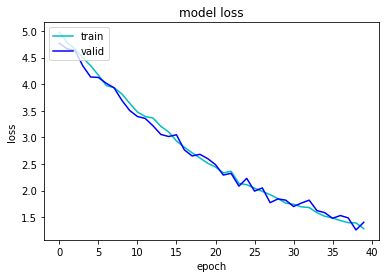

In [ ]:
# Summerize history for accuracy and loss
show_history(history_iv3)

# Efficient Net - Transfert Learning

In [11]:
height = 256
width = 256
input_shape = (height, width, 3)
dropout_rate = 0.2

In [12]:
num_classes = len(os.listdir('train'))
print(str(num_classes) + ' classes')

120 classes


## Importation des modèles



In [13]:
mod_bas_B0 = EfficientNetB0(weights='imagenet', include_top=False, input_shape= (256,256,3))
mod_bas_B1 = EfficientNetB1(weights='imagenet', include_top=False, input_shape= (256,256,3))
mod_bas_B2 = EfficientNetB2(weights='imagenet', include_top=False, input_shape= (256,256,3))
mod_bas_B3 = EfficientNetB3(weights='imagenet', include_top=False, input_shape= (256,256,3))
mod_bas_B4 = EfficientNetB4(weights='imagenet', include_top=False, input_shape= (256,256,3))
mod_bas_B5 = EfficientNetB5(weights='imagenet', include_top=False, input_shape= (256,256,3))

115269632/115263384 [==============================] - 1s 0us/step


## Modification des dernières couches

In [14]:
#seed = random.randint(1, 1000)
learning_rate = 0.0001
classes = 120

optimizer = Adam(lr=learning_rate)
#optimizer = RMSprop(lr=learning_rate)

loss = "categorical_crossentropy"
# loss = "kullback_leibler_divergence"

verbose = 1
batch_size = 40
epochs = 40  

### Base

In [ ]:
def transfert_efficientNet(model_name, nb_class):
#def transfert_efficientNet(model_name, model):

  model = Sequential()
  model.add(model_name)
  model.add(GlobalMaxPooling2D(name="gap"))
  model.add(Flatten(name="flatten"))
  
  model.add(Dropout(0.2, name="dropout_out"))
  model.add(Dense(256, activation='relu', name="fc1"))
  model.add(Dense(nb_class, activation='softmax', name="fc_out"))
  return model

In [ ]:
model_B0_base = transfert_efficientNet(mod_bas_B0, 120)
model_B0_base.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
efficientnetb0 (Functional)  (None, 8, 8, 1280)        4049571   
_________________________________________________________________
gap (GlobalMaxPooling2D)     (None, 1280)              0         
_________________________________________________________________
flatten (Flatten)            (None, 1280)              0         
_________________________________________________________________
dropout_out (Dropout)        (None, 1280)              0         
_________________________________________________________________
fc1 (Dense)                  (None, 256)               327936    
_________________________________________________________________
fc_out (Dense)               (None, 120)               30840     
Total params: 4,408,347
Trainable params: 4,366,324
Non-trainable params: 42,023
_________________________________________

In [ ]:
model_B0_base.compile(optimizer=optimizer,
              loss=loss,
              metrics=["accuracy"])

start = time.time()

history_B0_base = model_B0_base.fit(
      train_datagen,
      steps_per_epoch= np.ceil(400/batch_size),
      epochs=epochs,
      validation_data=test_datagen,
      validation_steps= np.ceil(100/batch_size),
      verbose=1)
print('Execution time: ', time.time()-start)

Epoch 1/40
10/10 [==============================] - 18s 896ms/step - loss: 14.4892 - accuracy: 0.0062 - val_loss: 5.5533 - val_accuracy: 0.0000e+00
Epoch 2/40
10/10 [==============================] - 8s 767ms/step - loss: 7.0021 - accuracy: 0.0288 - val_loss: 5.0870 - val_accuracy: 0.0208
Epoch 3/40
10/10 [==============================] - 9s 786ms/step - loss: 5.3714 - accuracy: 0.0421 - val_loss: 21.1152 - val_accuracy: 0.0000e+00
Epoch 4/40
10/10 [==============================] - 8s 768ms/step - loss: 4.6510 - accuracy: 0.0437 - val_loss: 6.0051 - val_accuracy: 0.0000e+00
Epoch 5/40
10/10 [==============================] - 8s 792ms/step - loss: 4.5011 - accuracy: 0.0543 - val_loss: 5.2515 - val_accuracy: 0.0000e+00
Epoch 6/40
10/10 [==============================] - 8s 769ms/step - loss: 4.3171 - accuracy: 0.0888 - val_loss: 5.2601 - val_accuracy: 0.0104
Epoch 7/40
10/10 [==============================] - 8s 787ms/step - loss: 4.3481 - accuracy: 0.0810 - val_loss: 5.2472 - val_accu

In [ ]:
model_B0_base = transfert_efficientNet(mod_bas_B0, 120)
model_B1_base = transfert_efficientNet(mod_bas_B1, 120)
model_B2_base = transfert_efficientNet(mod_bas_B2, 120)
model_B3_base = transfert_efficientNet(mod_bas_B3, 120)
model_B4_base = transfert_efficientNet(mod_bas_B4, 120)
model_B5_base = transfert_efficientNet(mod_bas_B5,120)

### Base simplifiée

In [ ]:

dropout_rate = 0.2
model_B0_simpl = Sequential()
model_B0_simpl.add(mod_bas_B0)
model_B0_simpl.add(GlobalMaxPooling2D(name="gap"))
if dropout_rate > 0:
    model_B0_simpl.add(Dropout(dropout_rate, name="dropout_out"))
model_B0_simpl.add(Dense(120, activation="softmax", name="fc_out"))
model_B0_simpl.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
efficientnetb0 (Functional)  (None, 8, 8, 1280)        4049571   
_________________________________________________________________
gap (GlobalMaxPooling2D)     (None, 1280)              0         
_________________________________________________________________
dropout_out (Dropout)        (None, 1280)              0         
_________________________________________________________________
fc_out (Dense)               (None, 120)               153720    
Total params: 4,203,291
Trainable params: 4,161,268
Non-trainable params: 42,023
_________________________________________________________________


In [ ]:
model_B0_simpl.compile(optimizer=optimizer,
              loss=loss,
              metrics=["accuracy"])

start = time.time()

history_B0_simpl = model_B0_simpl.fit_generator(
      train_datagen,
      steps_per_epoch= np.ceil(400/batch_size),
      epochs=epochs,
      validation_data=test_datagen,
      validation_steps= np.ceil(100/batch_size),
      verbose=1)
print('Execution time: ', time.time()-start)

Epoch 1/40


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


10/10 [==============================] - 18s 945ms/step - loss: 13.2371 - accuracy: 0.0040 - val_loss: 6.0158 - val_accuracy: 0.0104
Epoch 2/40
10/10 [==============================] - 8s 771ms/step - loss: 8.6406 - accuracy: 0.0359 - val_loss: 6.4193 - val_accuracy: 0.0000e+00
Epoch 3/40
10/10 [==============================] - 8s 764ms/step - loss: 6.0054 - accuracy: 0.0424 - val_loss: 5.6468 - val_accuracy: 0.0208
Epoch 4/40
10/10 [==============================] - 8s 764ms/step - loss: 4.7925 - accuracy: 0.1227 - val_loss: 5.7396 - val_accuracy: 0.0104
Epoch 5/40
10/10 [==============================] - 8s 765ms/step - loss: 3.9690 - accuracy: 0.1609 - val_loss: 5.4482 - val_accuracy: 0.0000e+00
Epoch 6/40
10/10 [==============================] - 8s 768ms/step - loss: 3.3915 - accuracy: 0.2652 - val_loss: 5.4145 - val_accuracy: 0.0104
Epoch 7/40
10/10 [==============================] - 8s 766ms/step - loss: 2.9811 - accuracy: 0.2725 - val_loss: 5.2635 - val_accuracy: 0.0521
Epoch 8

### TL-Proj6

In [ ]:
def extract_feat_effnet(model, nb_class):
  # Set up the layers to not trainable
  for layer in model.layers:
    layer.trainable = False

  # Add last layers
  avg = GlobalAveragePooling2D()(model.output)
  output = Dense(nb_class, activation = 'softmax')(avg)
  new_model = tf.keras.Model(inputs = model.input, outputs = output)
    
  # summarize the model
  new_model.summary()
  
  return new_model

In [ ]:
model_B0_EF = extract_feat_effnet(mod_bas_B0, 120)

Model: "model_15"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
rescaling (Rescaling)           (None, 256, 256, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
normalization (Normalization)   (None, 256, 256, 3)  7           rescaling[0][0]                  
__________________________________________________________________________________________________
stem_conv_pad (ZeroPadding2D)   (None, 257, 257, 3)  0           normalization[0][0]              
___________________________________________________________________________________________

In [ ]:
model_B0_EF = extract_feat_effnet(mod_bas_B0, 120)
model_B1_EF = extract_feat_effnet(mod_bas_B1, 120)
model_B2_EF = extract_feat_effnet(mod_bas_B2, 120)
model_B3_EF = extract_feat_effnet(mod_bas_B3, 120)
model_B4_EF = extract_feat_effnet(mod_bas_B4, 120)
model_B5_EF = extract_feat_effnet(mod_bas_B5, 120)

Le flux de sortie a été tronqué et ne contient que les 5000 dernières lignes.
__________________________________________________________________________________________________
block2a_dwconv (DepthwiseConv2D (None, 64, 64, 96)   864         block2a_dwconv_pad[0][0]         
__________________________________________________________________________________________________
block2a_bn (BatchNormalization) (None, 64, 64, 96)   384         block2a_dwconv[0][0]             
__________________________________________________________________________________________________
block2a_activation (Activation) (None, 64, 64, 96)   0           block2a_bn[0][0]                 
__________________________________________________________________________________________________
block2a_se_squeeze (GlobalAvera (None, 96)           0           block2a_activation[0][0]         
__________________________________________________________________________________________________
block2a_se_reshape (Reshape)   

In [ ]:
model_B0_EF.compile(optimizer=optimizer,
              loss=loss,
              metrics=["accuracy"])

start = time.time()

history_B0_EF = model_B0_EF.fit_generator(
      train_datagen,
      steps_per_epoch= np.ceil(400/batch_size),
      epochs=epochs,
      validation_data=test_datagen,
      validation_steps= np.ceil(100/batch_size),
      verbose=1)
print('Execution time: ', time.time()-start)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/40
10/10 [==============================] - 10s 454ms/step - loss: 4.7958 - accuracy: 0.0094 - val_loss: 4.8834 - val_accuracy: 0.0104
Epoch 2/40
10/10 [==============================] - 2s 217ms/step - loss: 4.9246 - accuracy: 0.0129 - val_loss: 4.8950 - val_accuracy: 0.0104
Epoch 3/40
10/10 [==============================] - 2s 221ms/step - loss: 4.8917 - accuracy: 0.0073 - val_loss: 4.8480 - val_accuracy: 0.0000e+00
Epoch 4/40
10/10 [==============================] - 2s 218ms/step - loss: 4.8587 - accuracy: 0.0101 - val_loss: 4.8058 - val_accuracy: 0.0208
Epoch 5/40
10/10 [==============================] - 2s 217ms/step - loss: 4.8758 - accuracy: 0.0055 - val_loss: 4.8321 - val_accuracy: 0.0000e+00
Epoch 6/40
10/10 [==============================] - 2s 218ms/step - loss: 4.8055 - accuracy: 8.8384e-04 - val_loss: 4.7883 - val_accuracy: 0.0000e+00
Epoch 7/40
10/10 [==============================] - 2s 218ms/step - loss: 4.8077 - accuracy: 0.0090 - val_loss: 4.8384 - val_accura

### Kaggle VarianceScaling

In [15]:
def tl_effnet_1(model, nb_classes):
  initializer = VarianceScaling(scale=0.1, mode='fan_in', distribution='uniform')
  x = model.output

  x = GlobalAveragePooling2D()(x)
  # x = Dropout(rate = .2)(x)
  x = BatchNormalization()(x)
  x = Dense(1280, activation='relu',  kernel_initializer=glorot_uniform(3), bias_initializer='zeros')(x)
  # x = Dropout(rate = .2)(x)
  x = BatchNormalization()(x)
  predictions = Dense(nb_classes, activation='softmax', kernel_initializer=initializer, bias_initializer='zeros')(x)

  new_model = tf.keras.Model(inputs=model.input, outputs=predictions)

  #for layer in new_model.layers:
  #   layer.trainable = True
  for layer in new_model.layers[-2:]:
      layer.trainable = True
  new_model.summary()
  return new_model

In [16]:
model_B0_vs = tl_effnet_1(mod_bas_B0, 120)
model_B1_vs = tl_effnet_1(mod_bas_B1, 120)
model_B2_vs = tl_effnet_1(mod_bas_B2, 120)
model_B3_vs = tl_effnet_1(mod_bas_B3, 120)
model_B4_vs = tl_effnet_1(mod_bas_B4, 120)

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
rescaling (Rescaling)           (None, 256, 256, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
normalization (Normalization)   (None, 256, 256, 3)  7           rescaling[0][0]                  
__________________________________________________________________________________________________
stem_conv_pad (ZeroPadding2D)   (None, 257, 257, 3)  0           normalization[0][0]              
______________________________________________________________________________________________

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/40
10/10 [==============================] - 144s 11s/step - loss: 4.8125 - accuracy: 0.0135 - val_loss: 4.7878 - val_accuracy: 0.0104
Epoch 2/40
10/10 [==============================] - 112s 12s/step - loss: 4.6787 - accuracy: 0.0531 - val_loss: 4.7844 - val_accuracy: 0.0417
Epoch 3/40
10/10 [==============================] - 107s 11s/step - loss: 4.5614 - accuracy: 0.0570 - val_loss: 4.7927 - val_accuracy: 0.0000e+00
Epoch 4/40
10/10 [==============================] - 101s 10s/step - loss: 4.4290 - accuracy: 0.1362 - val_loss: 4.7896 - val_accuracy: 0.0104
Epoch 5/40
10/10 [==============================] - 98s 10s/step - loss: 4.3071 - accuracy: 0.1607 - val_loss: 4.7906 - val_accuracy: 0.0208
Epoch 6/40
10/10 [==============================] - 93s 10s/step - loss: 4.1997 - accuracy: 0.1841 - val_loss: 4.7988 - val_accuracy: 0.0208
Epoch 7/40
10/10 [==============================] - 86s 9s/step - loss: 4.0735 - accuracy: 0.2193 - val_loss: 4.7946 - val_accuracy: 0.0000e+00
Ep

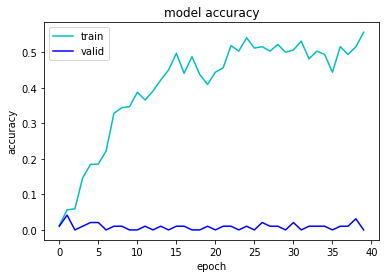

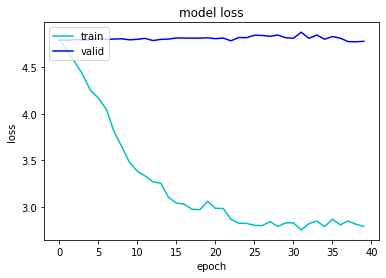

In [17]:
model_B0_vs.compile(loss="categorical_crossentropy", 
                optimizer=Adam(learning_rate=0.0001), 
                metrics=["accuracy"])

start = time.time()

history_B0_vs = model_B0_vs.fit_generator(
      train_datagen,
      steps_per_epoch= np.ceil(400/batch_size),
      epochs=epochs,
      validation_data=test_datagen,
      validation_steps= np.ceil(100/batch_size),
      verbose=verbose,
      callbacks = [reducelr])
print('Execution time: ', time.time()-start)

# Summerize history for accuracy and loss
show_history(history_B0_vs)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/40
10/10 [==============================] - 156s 14s/step - loss: 4.7885 - accuracy: 0.0072 - val_loss: 4.7927 - val_accuracy: 0.0000e+00
Epoch 2/40
10/10 [==============================] - 133s 14s/step - loss: 4.7269 - accuracy: 0.0359 - val_loss: 4.7895 - val_accuracy: 0.0000e+00
Epoch 3/40
10/10 [==============================] - 136s 14s/step - loss: 4.5488 - accuracy: 0.0937 - val_loss: 4.7934 - val_accuracy: 0.0000e+00
Epoch 4/40
10/10 [==============================] - 124s 13s/step - loss: 4.3808 - accuracy: 0.1817 - val_loss: 4.7896 - val_accuracy: 0.0104
Epoch 5/40
10/10 [==============================] - 121s 12s/step - loss: 4.1717 - accuracy: 0.2321 - val_loss: 4.7925 - val_accuracy: 0.0000e+00
Epoch 6/40
10/10 [==============================] - 110s 11s/step - loss: 3.9679 - accuracy: 0.3117 - val_loss: 4.7976 - val_accuracy: 0.0104
Epoch 7/40
10/10 [==============================] - 109s 11s/step - loss: 3.7465 - accuracy: 0.3870 - val_loss: 4.7934 - val_accurac

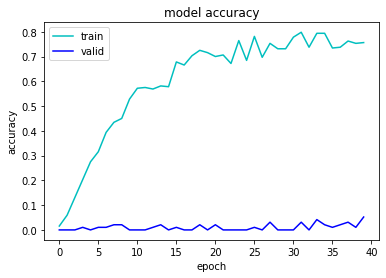

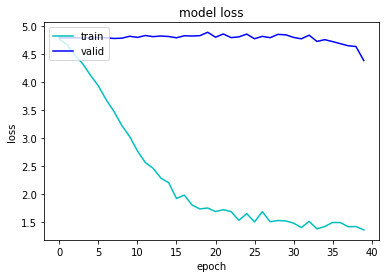

In [ ]:
model_B3_vs.compile(loss="categorical_crossentropy", 
                optimizer=Adam(learning_rate=0.0001), 
                metrics=["accuracy"])

start = time.time()

history_B3_vs = model_B3_vs.fit_generator(
      train_datagen,
      steps_per_epoch= np.ceil(400/batch_size),
      epochs=epochs,
      validation_data=test_datagen,
      validation_steps= np.ceil(100/batch_size),
      verbose=verbose,
      callbacks = [reducelr])
print('Execution time: ', time.time()-start)

# Summerize history for accuracy and loss
show_history(history_B3_vs)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/40
10/10 [==============================] - 41s 2s/step - loss: 4.8299 - accuracy: 0.0079 - val_loss: 4.7897 - val_accuracy: 0.0000e+00
Epoch 2/40
10/10 [==============================] - 31s 3s/step - loss: 4.7575 - accuracy: 0.0198 - val_loss: 4.7880 - val_accuracy: 0.0000e+00
Epoch 3/40
10/10 [==============================] - 24s 2s/step - loss: 4.6077 - accuracy: 0.0662 - val_loss: 4.7856 - val_accuracy: 0.0104
Epoch 4/40
10/10 [==============================] - 25s 3s/step - loss: 4.5032 - accuracy: 0.1018 - val_loss: 4.7896 - val_accuracy: 0.0000e+00
Epoch 5/40
10/10 [==============================] - 20s 2s/step - loss: 4.3866 - accuracy: 0.1288 - val_loss: 4.7896 - val_accuracy: 0.0000e+00
Epoch 6/40
10/10 [==============================] - 21s 2s/step - loss: 4.1977 - accuracy: 0.2417 - val_loss: 4.7895 - val_accuracy: 0.0104
Epoch 7/40
10/10 [==============================] - 21s 2s/step - loss: 4.1099 - accuracy: 0.2223 - val_loss: 4.7990 - val_accuracy: 0.0104
Epoc

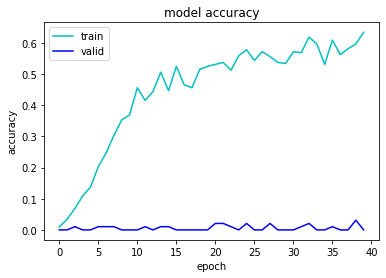

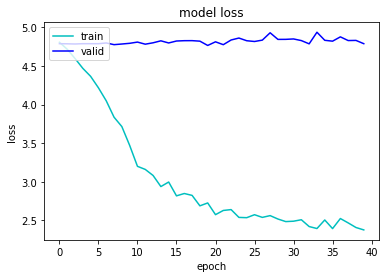

In [ ]:
model_B4_vs.compile(loss="categorical_crossentropy", 
                optimizer=Adam(learning_rate=0.0001), 
                metrics=["accuracy"])

start = time.time()

history_B4_vs = model_B4_vs.fit_generator(
      train_datagen,
      steps_per_epoch= np.ceil(400/batch_size),
      epochs=epochs,
      validation_data=test_datagen,
      validation_steps= np.ceil(100/batch_size),
      verbose=verbose,
      callbacks = [reducelr])
print('Execution time: ', time.time()-start)

# Summerize history for accuracy and loss
show_history(history_B4_vs)

### Kaggle RandomUniform

In [ ]:
def tl_effnet(model, nb_classes):
  x = model.output

  x = GlobalAveragePooling2D()(x)
  # x = Dropout(rate = .2)(x)
  x = BatchNormalization()(x)
  x = Dense(1280, activation='relu',  kernel_initializer=glorot_uniform(3), bias_initializer='zeros')(x)
  # x = Dropout(rate = .2)(x)
  x = BatchNormalization()(x)
  predictions = Dense(nb_classes, activation='softmax', kernel_initializer='random_uniform', bias_initializer='zeros')(x)

  new_model = tf.keras.Model(inputs=model.input, outputs=predictions)

  #for layer in new_model.layers:
   #  layer.trainable = True
  for layer in new_model.layers[-2:]:
      layer.trainable = True
  new_model.summary()
  return new_model


In [ ]:
model_B0_ru = tl_effnet(mod_bas_B0, 120)
model_B1_ru = tl_effnet(mod_bas_B1, 120)
model_B2_ru = tl_effnet(mod_bas_B2, 120)
model_B3_ru = tl_effnet(mod_bas_B3, 120)
model_B4_ru = tl_effnet(mod_bas_B4, 120)

Model: "model_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
rescaling (Rescaling)           (None, 256, 256, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
normalization (Normalization)   (None, 256, 256, 3)  7           rescaling[0][0]                  
__________________________________________________________________________________________________
stem_conv_pad (ZeroPadding2D)   (None, 257, 257, 3)  0           normalization[0][0]              
____________________________________________________________________________________________

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/40
10/10 [==============================] - 13s 579ms/step - loss: 5.1563 - accuracy: 0.0184 - val_loss: 4.7879 - val_accuracy: 0.0000e+00
Epoch 2/40
10/10 [==============================] - 5s 445ms/step - loss: 4.3476 - accuracy: 0.0828 - val_loss: 4.7814 - val_accuracy: 0.0000e+00
Epoch 3/40
10/10 [==============================] - 4s 446ms/step - loss: 3.8903 - accuracy: 0.1579 - val_loss: 4.7868 - val_accuracy: 0.0000e+00
Epoch 4/40
10/10 [==============================] - 4s 435ms/step - loss: 3.3452 - accuracy: 0.2386 - val_loss: 4.7847 - val_accuracy: 0.0312
Epoch 5/40
10/10 [==============================] - 4s 443ms/step - loss: 2.9066 - accuracy: 0.3208 - val_loss: 4.7901 - val_accuracy: 0.0104
Epoch 6/40
10/10 [==============================] - 4s 435ms/step - loss: 2.4094 - accuracy: 0.4635 - val_loss: 4.6910 - val_accuracy: 0.0312
Epoch 7/40
10/10 [==============================] - 5s 450ms/step - loss: 2.4190 - accuracy: 0.4271 - val_loss: 4.7959 - val_accuracy: 

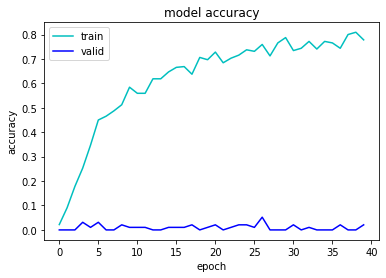

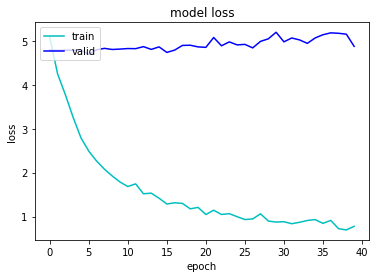

In [ ]:
model_B0_ru.compile(optimizer=optimizer,
              loss=loss,
              metrics=["accuracy"])

start = time.time()

history_B0_ru = model_B0_ru.fit_generator(
      train_datagen,
      steps_per_epoch= np.ceil(400/batch_size),
      epochs=epochs,
      validation_data=test_datagen,
      validation_steps= np.ceil(100/batch_size),
      verbose=1)
print('Execution time: ', time.time()-start)

# Summerize history for accuracy and loss
show_history(history_B0_ru)

### Comparaison

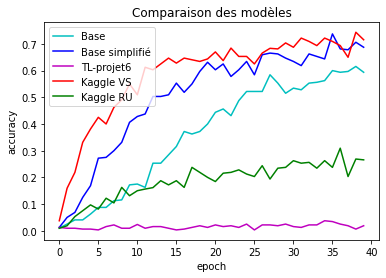

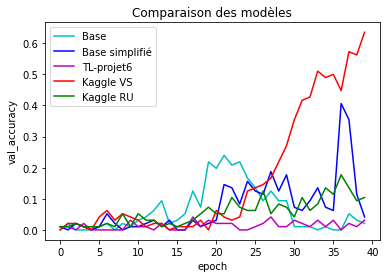

In [ ]:
# summarize history for accuracy
plt.plot(history_B0_base.history['accuracy'], 'c-')
plt.plot(history_B0_simpl.history['accuracy'], 'b-')
plt.plot(history_B0_EF.history['accuracy'], 'm-')
plt.plot(history_B0_vs.history['accuracy'], 'r-')
plt.plot(history_B0_ru.history['accuracy'], 'g-')
plt.title('Comparaison des modèles')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['Base', 'Base simplifié', 'TL-projet6', 'Kaggle VS', 'Kaggle RU'], loc='upper left')
plt.show()

# summarize history for validation accuracy 
plt.plot(history_B0_base.history['val_accuracy'], 'c-')
plt.plot(history_B0_simpl.history['val_accuracy'], 'b-')
plt.plot(history_B0_EF.history['val_accuracy'], 'm-')
plt.plot(history_B0_vs.history['val_accuracy'], 'r-')
plt.plot(history_B0_ru.history['val_accuracy'], 'g-')
plt.title('Comparaison des modèles')
plt.ylabel('val_accuracy')
plt.xlabel('epoch')
plt.legend(['Base', 'Base simplifié', 'TL-projet6', 'Kaggle VS', 'Kaggle RU'], loc='upper left')
plt.show()

# Implémentation de EfficientNet

# #EP=40/BS=40

In [ ]:
batch_size = 40
epochs = 40  

## EfficientNetB0

### SGD

In [ ]:
model_B0_ru.compile(loss="categorical_crossentropy", 
                optimizer=SGD(lr=0.0001, momentum=0.9), 
                metrics=["accuracy"])

start = time.time()

history_B0_rusgd = model_B0_ru.fit_generator(
      train_datagen,
      steps_per_epoch= np.ceil(400/batch_size),
      epochs=epochs,
      validation_data=test_datagen,
      validation_steps= np.ceil(100/batch_size),
      verbose=1,
      use_multiprocessing=False,
      workers=4)
print('Execution time: ', time.time()-start)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/40
10/10 [==============================] - 11s 437ms/step - loss: 3.1245 - accuracy: 0.2615 - val_loss: 4.0388 - val_accuracy: 0.1042
Epoch 2/40
10/10 [==============================] - 3s 260ms/step - loss: 3.2316 - accuracy: 0.2668 - val_loss: 4.0129 - val_accuracy: 0.1458
Epoch 3/40
10/10 [==============================] - 3s 251ms/step - loss: 3.3072 - accuracy: 0.2632 - val_loss: 4.0692 - val_accuracy: 0.1354
Epoch 4/40
10/10 [==============================] - 3s 257ms/step - loss: 3.2969 - accuracy: 0.2280 - val_loss: 4.0594 - val_accuracy: 0.1562
Epoch 5/40
10/10 [==============================] - 3s 256ms/step - loss: 3.3339 - accuracy: 0.3145 - val_loss: 3.6314 - val_accuracy: 0.2083
Epoch 6/40
10/10 [==============================] - 3s 258ms/step - loss: 3.4626 - accuracy: 0.2208 - val_loss: 4.0875 - val_accuracy: 0.1146
Epoch 7/40
10/10 [==============================] - 3s 257ms/step - loss: 3.4967 - accuracy: 0.2517 - val_loss: 3.7879 - val_accuracy: 0.2188
Epoch

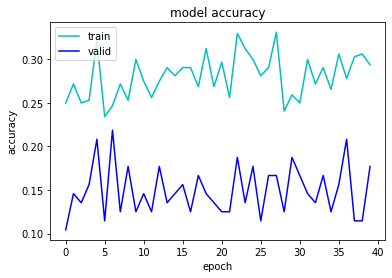

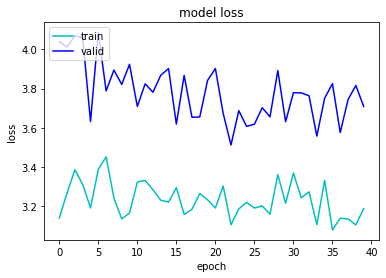

In [ ]:
# Summerize history for accuracy and loss
show_history(history_B0_rusgd)

### Adam

In [ ]:
model_B0_ru.compile(loss="categorical_crossentropy", 
                optimizer=Adam(learning_rate=0.0001), 
                metrics=["accuracy"])

start = time.time()

history_B0_ruadam = model_B0_ru.fit_generator(
      train_datagen,
      steps_per_epoch= np.ceil(400/batch_size),
      epochs=epochs,
      validation_data=test_datagen,
      validation_steps= np.ceil(100/batch_size),
      verbose=1,
      use_multiprocessing=False,
      workers=4)
print('Execution time: ', time.time()-start)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/40
10/10 [==============================] - 11s 433ms/step - loss: 3.2317 - accuracy: 0.3023 - val_loss: 3.4634 - val_accuracy: 0.1771
Epoch 2/40
10/10 [==============================] - 3s 261ms/step - loss: 3.2555 - accuracy: 0.3025 - val_loss: 3.7954 - val_accuracy: 0.1875
Epoch 3/40
10/10 [==============================] - 3s 255ms/step - loss: 3.0656 - accuracy: 0.3266 - val_loss: 3.7431 - val_accuracy: 0.1979
Epoch 4/40
10/10 [==============================] - 3s 258ms/step - loss: 3.3214 - accuracy: 0.2674 - val_loss: 3.7361 - val_accuracy: 0.1562
Epoch 5/40
10/10 [==============================] - 3s 262ms/step - loss: 3.1859 - accuracy: 0.2895 - val_loss: 3.6164 - val_accuracy: 0.2292
Epoch 6/40
10/10 [==============================] - 3s 254ms/step - loss: 3.2187 - accuracy: 0.3229 - val_loss: 3.7380 - val_accuracy: 0.1146
Epoch 7/40
10/10 [==============================] - 3s 253ms/step - loss: 3.1273 - accuracy: 0.2871 - val_loss: 3.7066 - val_accuracy: 0.1250
Epoch

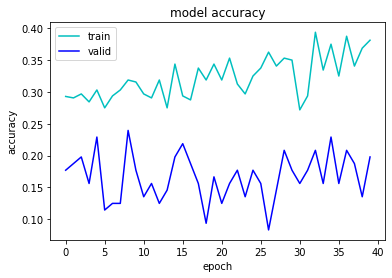

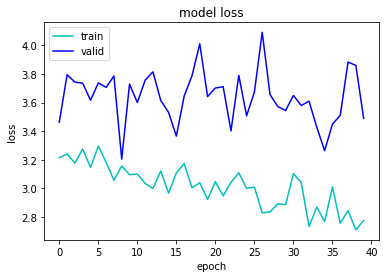

In [ ]:
# Summerize history for accuracy and loss
show_history(history_B0_ruadam)

### Adagrad

In [ ]:
model_B0_ru.compile(loss="categorical_crossentropy", 
                optimizer=Adagrad(learning_rate=0.001), 
                metrics=["accuracy"])

start = time.time()

history_B0_ruadag = model_B0_ru.fit_generator(
      train_datagen,
      steps_per_epoch= np.ceil(400/batch_size),
      epochs=epochs,
      validation_data=test_datagen,
      validation_steps= np.ceil(100/batch_size),
      verbose=1,
      use_multiprocessing=False,
      workers=4)
print('Execution time: ', time.time()-start)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/40
10/10 [==============================] - 11s 440ms/step - loss: 2.9457 - accuracy: 0.2955 - val_loss: 3.5791 - val_accuracy: 0.1771
Epoch 2/40
10/10 [==============================] - 3s 260ms/step - loss: 2.9514 - accuracy: 0.3352 - val_loss: 3.3418 - val_accuracy: 0.2500
Epoch 3/40
10/10 [==============================] - 3s 263ms/step - loss: 2.8555 - accuracy: 0.3656 - val_loss: 3.2544 - val_accuracy: 0.2500
Epoch 4/40
10/10 [==============================] - 3s 254ms/step - loss: 2.7870 - accuracy: 0.3563 - val_loss: 3.5253 - val_accuracy: 0.1875
Epoch 5/40
10/10 [==============================] - 3s 254ms/step - loss: 2.9154 - accuracy: 0.3598 - val_loss: 3.3979 - val_accuracy: 0.2500
Epoch 6/40
10/10 [==============================] - 3s 259ms/step - loss: 2.6254 - accuracy: 0.4635 - val_loss: 3.7565 - val_accuracy: 0.2292
Epoch 7/40
10/10 [==============================] - 3s 259ms/step - loss: 2.8455 - accuracy: 0.3469 - val_loss: 3.6834 - val_accuracy: 0.2188
Epoch

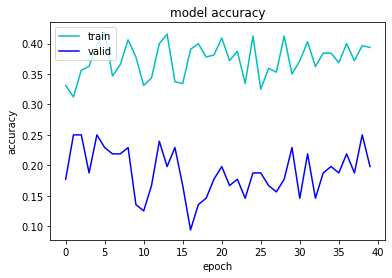

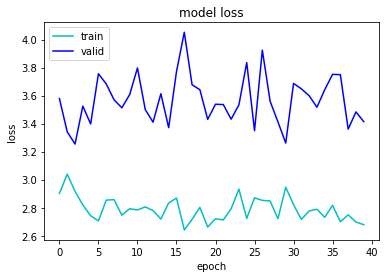

In [ ]:
# Summerize history for accuracy and loss
show_history(history_B0_ruadag)

### Adadelta

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/40
10/10 [==============================] - 10s 402ms/step - loss: 2.6447 - accuracy: 0.3766 - val_loss: 3.5312 - val_accuracy: 0.2500
Epoch 2/40
10/10 [==============================] - 2s 221ms/step - loss: 2.6340 - accuracy: 0.4069 - val_loss: 3.4093 - val_accuracy: 0.1979
Epoch 3/40
10/10 [==============================] - 2s 222ms/step - loss: 2.7306 - accuracy: 0.3498 - val_loss: 3.4769 - val_accuracy: 0.2396
Epoch 4/40
10/10 [==============================] - 2s 221ms/step - loss: 2.8439 - accuracy: 0.3954 - val_loss: 3.7379 - val_accuracy: 0.1354
Epoch 5/40
10/10 [==============================] - 2s 223ms/step - loss: 2.6354 - accuracy: 0.4096 - val_loss: 3.7352 - val_accuracy: 0.1250
Epoch 6/40
10/10 [==============================] - 2s 227ms/step - loss: 2.5990 - accuracy: 0.4370 - val_loss: 3.4420 - val_accuracy: 0.2188
Epoch 7/40
10/10 [==============================] - 2s 224ms/step - loss: 2.8003 - accuracy: 0.3461 - val_loss: 3.6203 - val_accuracy: 0.1875
Epoch

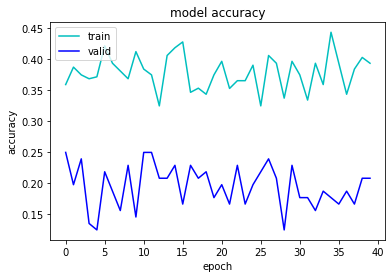

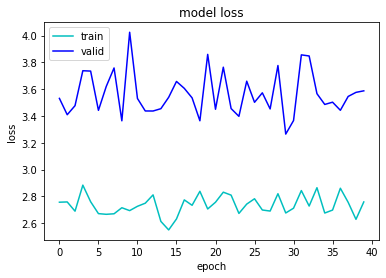

In [ ]:
model_B0_ru.compile(loss='categorical_crossentropy',
              optimizer=Adadelta(learning_rate=0.001), 
                metrics=["accuracy"])

start = time.time()

history_B0_ruadad = model_B0_ru.fit_generator(
      train_datagen,
      steps_per_epoch= np.ceil(400/batch_size),
      epochs=epochs,
      validation_data=test_datagen,
      validation_steps= np.ceil(100/batch_size),
      verbose=1)
print('Execution time: ', time.time()-start)

# Summerize history for accuracy and loss
show_history(history_B0_ruadad)

### RMSprop

In [ ]:
model_B0_ru.compile(loss='categorical_crossentropy',
              optimizer=RMSprop(lr=2e-5),
              metrics=['accuracy'])

start = time.time()

history_B0_rurms = model_B0_ru.fit_generator(
      train_datagen,
      steps_per_epoch= np.ceil(400/batch_size),
      epochs=epochs,
      validation_data=test_datagen,
      validation_steps= np.ceil(100/batch_size),
      verbose=1,
      use_multiprocessing=False,
      workers=4)
print('Execution time: ', time.time()-start)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/40
10/10 [==============================] - 12s 434ms/step - loss: 2.8509 - accuracy: 0.3243 - val_loss: 3.4937 - val_accuracy: 0.2188
Epoch 2/40
10/10 [==============================] - 3s 260ms/step - loss: 2.6735 - accuracy: 0.3539 - val_loss: 3.6162 - val_accuracy: 0.1667
Epoch 3/40
10/10 [==============================] - 3s 259ms/step - loss: 2.7543 - accuracy: 0.3953 - val_loss: 3.6808 - val_accuracy: 0.1146
Epoch 4/40
10/10 [==============================] - 3s 259ms/step - loss: 2.5844 - accuracy: 0.4228 - val_loss: 3.6952 - val_accuracy: 0.2083
Epoch 5/40
10/10 [==============================] - 3s 259ms/step - loss: 2.8224 - accuracy: 0.3330 - val_loss: 3.4474 - val_accuracy: 0.2083
Epoch 6/40
10/10 [==============================] - 3s 251ms/step - loss: 2.8033 - accuracy: 0.3255 - val_loss: 3.2943 - val_accuracy: 0.1875
Epoch 7/40
10/10 [==============================] - 3s 259ms/step - loss: 2.9422 - accuracy: 0.3681 - val_loss: 3.1105 - val_accuracy: 0.2708
Epoch

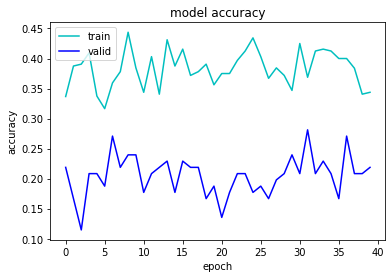

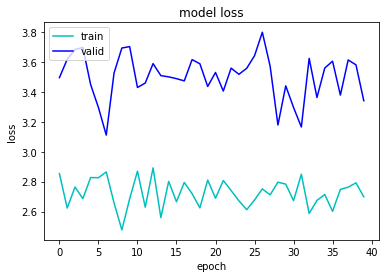

In [ ]:
# Summerize history for accuracy and loss
show_history(history_B0_rurms)

### Comparaison

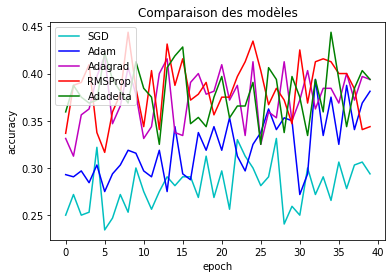

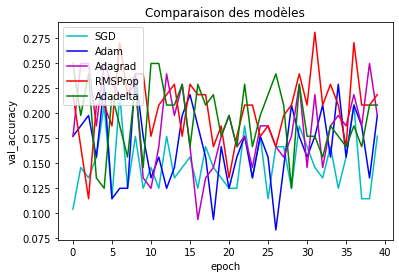

In [ ]:
# summarize history for accuracy
plt.plot(history_B0_rusgd.history['accuracy'], 'c-')
plt.plot(history_B0_ruadam.history['accuracy'], 'b-')
plt.plot(history_B0_ruadag.history['accuracy'], 'm-')
plt.plot(history_B0_rurms.history['accuracy'], 'r-')
plt.plot(history_B0_ruadad.history['accuracy'], 'g-')
plt.title('Comparaison des modèles')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['SGD', 'Adam', 'Adagrad', 'RMSProp', 'Adadelta'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(history_B0_rusgd.history['val_accuracy'], 'c-')
plt.plot(history_B0_ruadam.history['val_accuracy'], 'b-')
plt.plot(history_B0_ruadag.history['val_accuracy'], 'm-')
plt.plot(history_B0_rurms.history['val_accuracy'], 'r-')
plt.plot(history_B0_ruadad.history['val_accuracy'], 'g-')
plt.title('Comparaison des modèles')
plt.ylabel('val_accuracy')
plt.xlabel('epoch')
plt.legend(['SGD', 'Adam', 'Adagrad', 'RMSProp', 'Adadelta'], loc='upper left')
plt.show()

## EfficientNetB1

### SGD

In [ ]:
model_B1_ru.compile(loss="categorical_crossentropy", 
                optimizer=SGD(lr=0.0001, momentum=0.9), 
                metrics=["accuracy"])

start = time.time()

history_B1_rusgd = model_B1_ru.fit_generator(
      train_datagen,
      steps_per_epoch= np.ceil(400/batch_size),
      epochs=epochs,
      validation_data=test_datagen,
      validation_steps= np.ceil(100/batch_size),
      verbose=1,
      use_multiprocessing=False,
      workers=4)
print('Execution time: ', time.time()-start)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/40
10/10 [==============================] - 18s 830ms/step - loss: 5.3214 - accuracy: 0.0113 - val_loss: 4.7855 - val_accuracy: 0.0104
Epoch 2/40
10/10 [==============================] - 7s 647ms/step - loss: 5.3568 - accuracy: 0.0189 - val_loss: 4.7935 - val_accuracy: 0.0000e+00
Epoch 3/40
10/10 [==============================] - 7s 644ms/step - loss: 5.2417 - accuracy: 0.0122 - val_loss: 4.7939 - val_accuracy: 0.0104
Epoch 4/40
10/10 [==============================] - 7s 646ms/step - loss: 5.1870 - accuracy: 0.0000e+00 - val_loss: 4.7763 - val_accuracy: 0.0000e+00
Epoch 5/40
10/10 [==============================] - 7s 661ms/step - loss: 5.2298 - accuracy: 0.0048 - val_loss: 4.8227 - val_accuracy: 0.0104
Epoch 6/40
10/10 [==============================] - 7s 648ms/step - loss: 5.1853 - accuracy: 0.0176 - val_loss: 4.7999 - val_accuracy: 0.0104
Epoch 7/40
10/10 [==============================] - 7s 640ms/step - loss: 5.2306 - accuracy: 0.0034 - val_loss: 4.8151 - val_accuracy: 

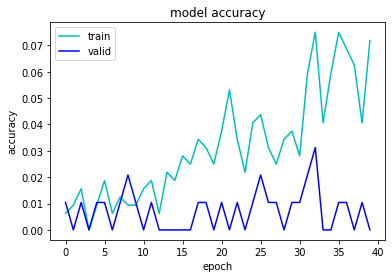

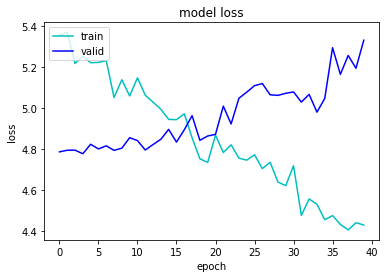

In [ ]:
# Summerize history for accuracy and loss
show_history(history_B1_rusgd)

### Adam

In [ ]:
model_B1_ru.compile(loss="categorical_crossentropy", 
                optimizer=Adam(learning_rate=0.0001), 
                metrics=["accuracy"])

start = time.time()

history_B1_ruadam = model_B1_ru.fit_generator(
      train_datagen,
      steps_per_epoch= np.ceil(400/batch_size),
      epochs=epochs,
      validation_data=test_datagen,
      validation_steps= np.ceil(100/batch_size),
      verbose=1,
      use_multiprocessing=False,
      workers=4)
print('Execution time: ', time.time()-start)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/40
10/10 [==============================] - 19s 829ms/step - loss: 4.2478 - accuracy: 0.0814 - val_loss: 5.3230 - val_accuracy: 0.0208
Epoch 2/40
10/10 [==============================] - 7s 639ms/step - loss: 3.9848 - accuracy: 0.1484 - val_loss: 5.4405 - val_accuracy: 0.0000e+00
Epoch 3/40
10/10 [==============================] - 7s 644ms/step - loss: 3.9323 - accuracy: 0.1136 - val_loss: 5.3820 - val_accuracy: 0.0000e+00
Epoch 4/40
10/10 [==============================] - 7s 642ms/step - loss: 3.5575 - accuracy: 0.1562 - val_loss: 5.1941 - val_accuracy: 0.0208
Epoch 5/40
10/10 [==============================] - 7s 651ms/step - loss: 3.2318 - accuracy: 0.2813 - val_loss: 5.2777 - val_accuracy: 0.0000e+00
Epoch 6/40
10/10 [==============================] - 7s 648ms/step - loss: 2.8695 - accuracy: 0.3162 - val_loss: 5.0606 - val_accuracy: 0.0104
Epoch 7/40
10/10 [==============================] - 7s 646ms/step - loss: 2.6680 - accuracy: 0.3542 - val_loss: 5.1290 - val_accuracy: 

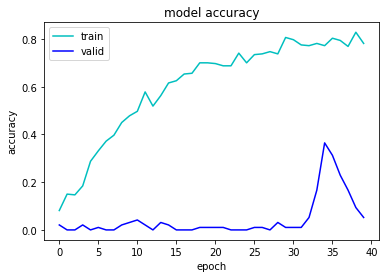

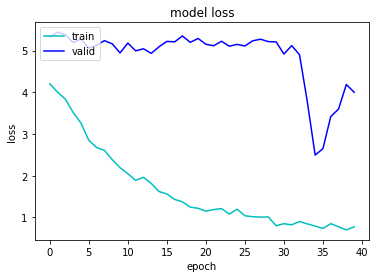

In [ ]:
# Summerize history for accuracy and loss
show_history(history_B1_ruadam)

### Adagrad

In [ ]:
model_B1_ru.compile(loss="categorical_crossentropy", 
                optimizer=Adagrad(learning_rate=0.001), 
                metrics=["accuracy"])

start = time.time()

history_B1_ruadag = model_B1_ru.fit_generator(
      train_datagen,
      steps_per_epoch= np.ceil(400/batch_size),
      epochs=epochs,
      validation_data=test_datagen,
      validation_steps= np.ceil(100/batch_size),
      verbose=1,
      use_multiprocessing=False,
      workers=4)
print('Execution time: ', time.time()-start)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/40
10/10 [==============================] - 18s 823ms/step - loss: 0.6450 - accuracy: 0.8435 - val_loss: 4.4060 - val_accuracy: 0.0938
Epoch 2/40
10/10 [==============================] - 7s 640ms/step - loss: 0.7162 - accuracy: 0.8004 - val_loss: 5.2725 - val_accuracy: 0.0104
Epoch 3/40
10/10 [==============================] - 7s 647ms/step - loss: 0.6912 - accuracy: 0.7937 - val_loss: 5.1229 - val_accuracy: 0.0104
Epoch 4/40
10/10 [==============================] - 7s 646ms/step - loss: 0.8029 - accuracy: 0.7905 - val_loss: 4.5474 - val_accuracy: 0.0833
Epoch 5/40
10/10 [==============================] - 7s 651ms/step - loss: 0.6360 - accuracy: 0.8491 - val_loss: 3.6365 - val_accuracy: 0.1979
Epoch 6/40
10/10 [==============================] - 7s 646ms/step - loss: 0.7004 - accuracy: 0.7930 - val_loss: 4.8804 - val_accuracy: 0.0312
Epoch 7/40
10/10 [==============================] - 7s 651ms/step - loss: 0.5961 - accuracy: 0.8309 - val_loss: 5.0368 - val_accuracy: 0.0104
Epoch

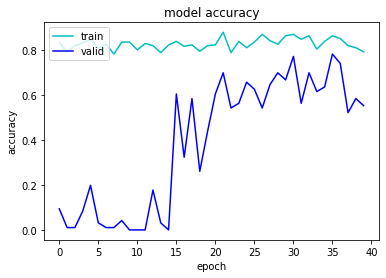

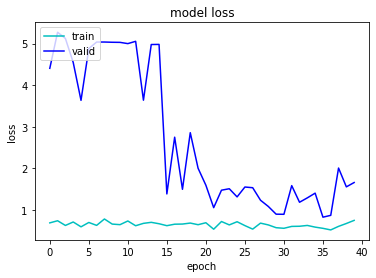

In [ ]:
# Summerize history for accuracy and loss
show_history(history_B1_ruadag)

### RMSprop

In [ ]:
model_B1_ru.compile(loss='categorical_crossentropy',
              optimizer=RMSprop(lr=2e-5),
              metrics=['accuracy'])

start = time.time()

history_B1_rurms = model_B1_ru.fit_generator(
      train_datagen,
      steps_per_epoch= np.ceil(400/batch_size),
      epochs=epochs,
      validation_data=test_datagen,
      validation_steps= np.ceil(100/batch_size),
      verbose=1,
      use_multiprocessing=False,
      workers=4)
print('Execution time: ', time.time()-start)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/40
10/10 [==============================] - 25s 826ms/step - loss: 0.6608 - accuracy: 0.8404 - val_loss: 1.7651 - val_accuracy: 0.4896
Epoch 2/40
10/10 [==============================] - 7s 648ms/step - loss: 0.5170 - accuracy: 0.8515 - val_loss: 1.6184 - val_accuracy: 0.5625
Epoch 3/40
10/10 [==============================] - 7s 654ms/step - loss: 0.5605 - accuracy: 0.8899 - val_loss: 1.5721 - val_accuracy: 0.6042
Epoch 4/40
10/10 [==============================] - 7s 651ms/step - loss: 0.6236 - accuracy: 0.8049 - val_loss: 1.4392 - val_accuracy: 0.6146
Epoch 5/40
10/10 [==============================] - 6s 615ms/step - loss: 0.4709 - accuracy: 0.9078 - val_loss: 1.2852 - val_accuracy: 0.6458
Epoch 6/40
10/10 [==============================] - 7s 660ms/step - loss: 0.6907 - accuracy: 0.8093 - val_loss: 1.1189 - val_accuracy: 0.7083
Epoch 7/40
10/10 [==============================] - 6s 664ms/step - loss: 0.7173 - accuracy: 0.8200 - val_loss: 1.1344 - val_accuracy: 0.6667
Epoch

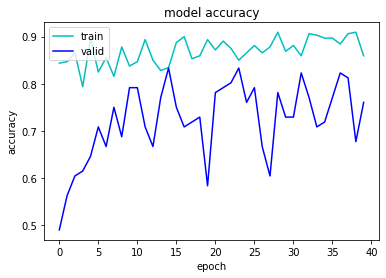

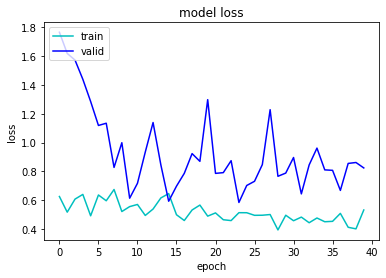

In [ ]:
# Summerize history for accuracy and loss
show_history(history_B1_rurms)

### Adadelta

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/40
10/10 [==============================] - 18s 826ms/step - loss: 0.4094 - accuracy: 0.8925 - val_loss: 0.6723 - val_accuracy: 0.8125
Epoch 2/40
10/10 [==============================] - 7s 633ms/step - loss: 0.4651 - accuracy: 0.8715 - val_loss: 0.6865 - val_accuracy: 0.7396
Epoch 3/40
10/10 [==============================] - 7s 646ms/step - loss: 0.4098 - accuracy: 0.9130 - val_loss: 0.7285 - val_accuracy: 0.7604
Epoch 4/40
10/10 [==============================] - 7s 642ms/step - loss: 0.4688 - accuracy: 0.8671 - val_loss: 0.6849 - val_accuracy: 0.7396
Epoch 5/40
10/10 [==============================] - 7s 652ms/step - loss: 0.4317 - accuracy: 0.9014 - val_loss: 0.8490 - val_accuracy: 0.7708
Epoch 6/40
10/10 [==============================] - 7s 643ms/step - loss: 0.4722 - accuracy: 0.8794 - val_loss: 0.7685 - val_accuracy: 0.7708
Epoch 7/40
10/10 [==============================] - 7s 644ms/step - loss: 0.4900 - accuracy: 0.8922 - val_loss: 0.8472 - val_accuracy: 0.6979
Epoch

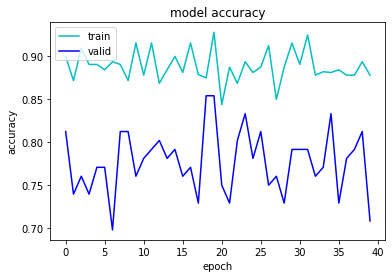

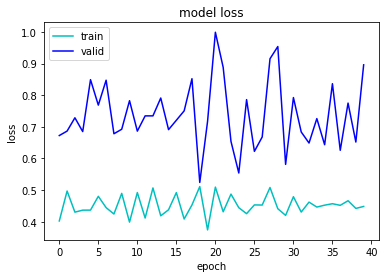

In [ ]:
model_B1_ru.compile(loss='categorical_crossentropy',
              optimizer=Adadelta(learning_rate=0.001), 
                metrics=["accuracy"])

start = time.time()

history_B1_ruadad = model_B1_ru.fit_generator(
      train_datagen,
      steps_per_epoch= np.ceil(400/batch_size),
      epochs=epochs,
      validation_data=test_datagen,
      validation_steps= np.ceil(100/batch_size),
      verbose=1,
      use_multiprocessing=False,
      workers=4)
print('Execution time: ', time.time()-start)

# Summerize history for accuracy and loss
show_history(history_B1_ruadad)

### Comparaison

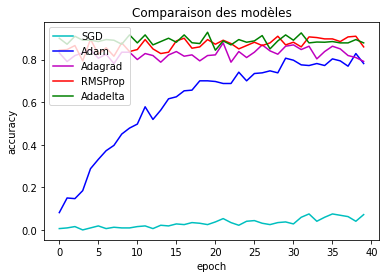

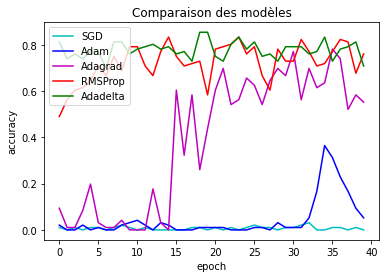

In [ ]:
# summarize history for accuracy
plt.plot(history_B1_rusgd.history['accuracy'], 'c-')
plt.plot(history_B1_ruadam.history['accuracy'], 'b-')
plt.plot(history_B1_ruadag.history['accuracy'], 'm-')
plt.plot(history_B1_rurms.history['accuracy'], 'r-')
plt.plot(history_B1_ruadad.history['accuracy'], 'g-')
plt.title('Comparaison des modèles')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['SGD', 'Adam', 'Adagrad', 'RMSProp', 'Adadelta'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(history_B1_rusgd.history['val_accuracy'], 'c-')
plt.plot(history_B1_ruadam.history['val_accuracy'], 'b-')
plt.plot(history_B1_ruadag.history['val_accuracy'], 'm-')
plt.plot(history_B1_rurms.history['val_accuracy'], 'r-')
plt.plot(history_B1_ruadad.history['val_accuracy'], 'g-')
plt.title('Comparaison des modèles')
plt.ylabel('val_accuracy')
plt.xlabel('epoch')
plt.legend(['SGD', 'Adam', 'Adagrad', 'RMSProp', 'Adadelta'], loc='upper left')
plt.show()

## EfficientNetB2

### SGD

In [ ]:
model_B2_ru.compile(loss="categorical_crossentropy", 
                optimizer=SGD(lr=0.0001, momentum=0.9), 
                metrics=["accuracy"])

start = time.time()

history_B2_rusgd = model_B2_ru.fit_generator(
      train_datagen,
      steps_per_epoch= np.ceil(400/batch_size),
      epochs=epochs,
      validation_data=test_datagen,
      validation_steps= np.ceil(100/batch_size),
      verbose=1,
      use_multiprocessing=False,
      workers=4)
print('Execution time: ', time.time()-start)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/40
10/10 [==============================] - 20s 859ms/step - loss: 5.2308 - accuracy: 0.0198 - val_loss: 4.7802 - val_accuracy: 0.0104
Epoch 2/40
10/10 [==============================] - 7s 668ms/step - loss: 5.3638 - accuracy: 0.0133 - val_loss: 4.8048 - val_accuracy: 0.0208
Epoch 3/40
10/10 [==============================] - 7s 668ms/step - loss: 5.3089 - accuracy: 0.0058 - val_loss: 4.7939 - val_accuracy: 0.0000e+00
Epoch 4/40
10/10 [==============================] - 7s 678ms/step - loss: 5.1926 - accuracy: 0.0000e+00 - val_loss: 4.7980 - val_accuracy: 0.0104
Epoch 5/40
10/10 [==============================] - 7s 668ms/step - loss: 5.2965 - accuracy: 0.0108 - val_loss: 4.8166 - val_accuracy: 0.0000e+00
Epoch 6/40
10/10 [==============================] - 7s 670ms/step - loss: 5.2150 - accuracy: 0.0179 - val_loss: 4.8201 - val_accuracy: 0.0104
Epoch 7/40
10/10 [==============================] - 7s 677ms/step - loss: 5.2055 - accuracy: 0.0115 - val_loss: 4.7955 - val_accuracy: 

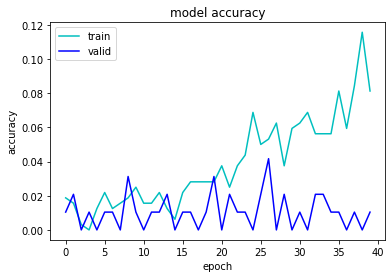

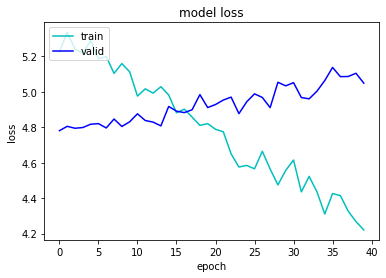

In [ ]:
# Summerize history for accuracy and loss
show_history(history_B2_rusgd)

### Adam

In [ ]:
model_B2_ru.compile(loss="categorical_crossentropy", 
                optimizer=Adam(learning_rate=0.0001), 
                metrics=["accuracy"])

start = time.time()

history_B2_ruadam = model_B2_ru.fit_generator(
      train_datagen,
      steps_per_epoch= np.ceil(400/batch_size),
      epochs=epochs,
      validation_data=test_datagen,
      validation_steps= np.ceil(100/batch_size),
      verbose=1,
      use_multiprocessing=False,
      workers=4)
print('Execution time: ', time.time()-start)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/40
10/10 [==============================] - 18s 862ms/step - loss: 4.0986 - accuracy: 0.1033 - val_loss: 4.9634 - val_accuracy: 0.0000e+00
Epoch 2/40
10/10 [==============================] - 7s 679ms/step - loss: 3.7579 - accuracy: 0.1881 - val_loss: 5.2313 - val_accuracy: 0.0104
Epoch 3/40
10/10 [==============================] - 7s 679ms/step - loss: 3.6202 - accuracy: 0.2252 - val_loss: 5.3642 - val_accuracy: 0.0000e+00
Epoch 4/40
10/10 [==============================] - 7s 673ms/step - loss: 3.4507 - accuracy: 0.2348 - val_loss: 5.2896 - val_accuracy: 0.0000e+00
Epoch 5/40
10/10 [==============================] - 7s 675ms/step - loss: 3.0764 - accuracy: 0.3356 - val_loss: 5.1473 - val_accuracy: 0.0000e+00
Epoch 6/40
10/10 [==============================] - 7s 674ms/step - loss: 2.7012 - accuracy: 0.3779 - val_loss: 5.3193 - val_accuracy: 0.0417
Epoch 7/40
10/10 [==============================] - 7s 677ms/step - loss: 2.6963 - accuracy: 0.3828 - val_loss: 5.3863 - val_accura

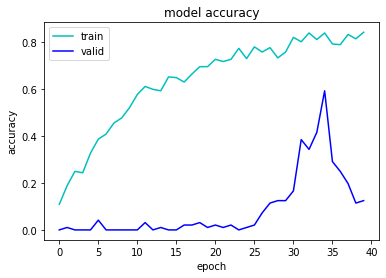

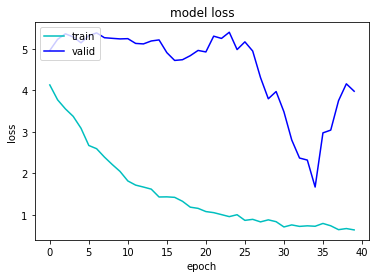

In [ ]:
# Summerize history for accuracy and loss
show_history(history_B2_ruadam)

### Adagrad

In [ ]:
model_B2_ru.compile(loss="categorical_crossentropy", 
                optimizer=Adagrad(learning_rate=0.001), 
                metrics=["accuracy"])

start = time.time()

history_B2_ruadag = model_B2_ru.fit_generator(
      train_datagen,
      steps_per_epoch= np.ceil(400/batch_size),
      epochs=epochs,
      validation_data=test_datagen,
      validation_steps= np.ceil(100/batch_size),
      verbose=1,
      use_multiprocessing=False,
      workers=4)
print('Execution time: ', time.time()-start)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/40
10/10 [==============================] - 18s 849ms/step - loss: 0.6021 - accuracy: 0.8450 - val_loss: 4.5323 - val_accuracy: 0.0729
Epoch 2/40
10/10 [==============================] - 7s 663ms/step - loss: 0.6720 - accuracy: 0.8295 - val_loss: 3.8747 - val_accuracy: 0.1042
Epoch 3/40
10/10 [==============================] - 7s 671ms/step - loss: 0.7711 - accuracy: 0.7939 - val_loss: 4.4204 - val_accuracy: 0.0729
Epoch 4/40
10/10 [==============================] - 7s 675ms/step - loss: 0.6732 - accuracy: 0.8064 - val_loss: 4.2121 - val_accuracy: 0.1042
Epoch 5/40
10/10 [==============================] - 7s 678ms/step - loss: 0.5108 - accuracy: 0.8457 - val_loss: 4.0852 - val_accuracy: 0.1562
Epoch 6/40
10/10 [==============================] - 7s 673ms/step - loss: 0.6065 - accuracy: 0.8444 - val_loss: 3.3720 - val_accuracy: 0.2188
Epoch 7/40
10/10 [==============================] - 7s 667ms/step - loss: 0.5574 - accuracy: 0.8692 - val_loss: 2.5258 - val_accuracy: 0.3542
Epoch

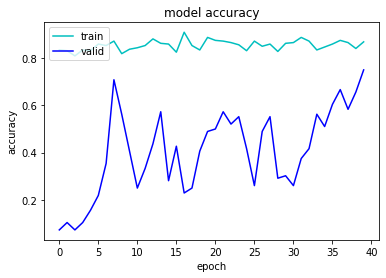

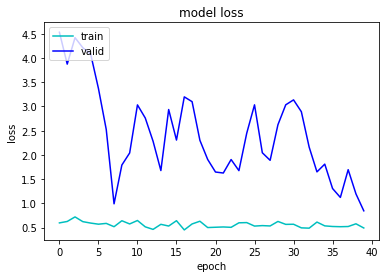

In [ ]:
# Summerize history for accuracy and loss
show_history(history_B2_ruadag)

### RMSprop

In [ ]:
model_B2_ru.compile(loss='categorical_crossentropy',
              optimizer=RMSprop(lr=2e-5),
              metrics=['accuracy'])

start = time.time()

history_B2_rurms = model_B2_ru.fit_generator(
      train_datagen,
      steps_per_epoch= np.ceil(400/batch_size),
      epochs=epochs,
      validation_data=test_datagen,
      validation_steps= np.ceil(100/batch_size),
      verbose=1,
      use_multiprocessing=False,
      workers=4)
print('Execution time: ', time.time()-start)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/40
10/10 [==============================] - 26s 856ms/step - loss: 0.5246 - accuracy: 0.8344 - val_loss: 0.8838 - val_accuracy: 0.7292
Epoch 2/40
10/10 [==============================] - 7s 678ms/step - loss: 0.5194 - accuracy: 0.8860 - val_loss: 0.8134 - val_accuracy: 0.7396
Epoch 3/40
10/10 [==============================] - 7s 678ms/step - loss: 0.4379 - accuracy: 0.9026 - val_loss: 0.9380 - val_accuracy: 0.7188
Epoch 4/40
10/10 [==============================] - 7s 681ms/step - loss: 0.5141 - accuracy: 0.8582 - val_loss: 1.0480 - val_accuracy: 0.6979
Epoch 5/40
10/10 [==============================] - 7s 685ms/step - loss: 0.5397 - accuracy: 0.8414 - val_loss: 0.7625 - val_accuracy: 0.7604
Epoch 6/40
10/10 [==============================] - 7s 686ms/step - loss: 0.5203 - accuracy: 0.8716 - val_loss: 0.9708 - val_accuracy: 0.6979
Epoch 7/40
10/10 [==============================] - 7s 683ms/step - loss: 0.4430 - accuracy: 0.8508 - val_loss: 0.9222 - val_accuracy: 0.7292
Epoch

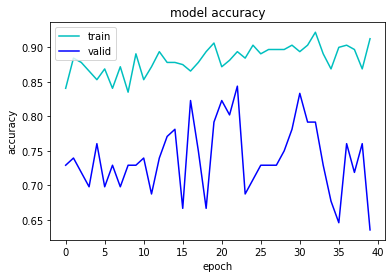

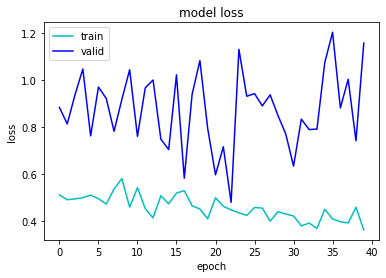

In [ ]:
# Summerize history for accuracy and loss
show_history(history_B2_rurms)

### Adadelta

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/40
10/10 [==============================] - 18s 864ms/step - loss: 0.4104 - accuracy: 0.8987 - val_loss: 0.8727 - val_accuracy: 0.7083
Epoch 2/40
10/10 [==============================] - 7s 669ms/step - loss: 0.3675 - accuracy: 0.9274 - val_loss: 0.9511 - val_accuracy: 0.7188
Epoch 3/40
10/10 [==============================] - 7s 675ms/step - loss: 0.4384 - accuracy: 0.9015 - val_loss: 0.8303 - val_accuracy: 0.7604
Epoch 4/40
10/10 [==============================] - 7s 682ms/step - loss: 0.3466 - accuracy: 0.9049 - val_loss: 0.5378 - val_accuracy: 0.8229
Epoch 5/40
10/10 [==============================] - 7s 676ms/step - loss: 0.4008 - accuracy: 0.8974 - val_loss: 0.7549 - val_accuracy: 0.7500
Epoch 6/40
10/10 [==============================] - 7s 670ms/step - loss: 0.3910 - accuracy: 0.9036 - val_loss: 0.8275 - val_accuracy: 0.7188
Epoch 7/40
10/10 [==============================] - 7s 671ms/step - loss: 0.3913 - accuracy: 0.9007 - val_loss: 0.5452 - val_accuracy: 0.8229
Epoch

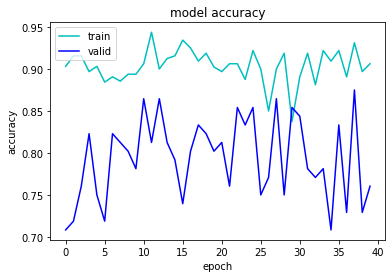

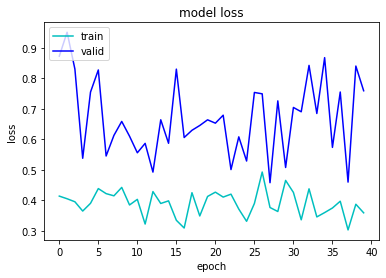

In [ ]:
model_B2_ru.compile(loss='categorical_crossentropy',
              optimizer=Adadelta(learning_rate=0.001), 
                metrics=["accuracy"])

start = time.time()

history_B2_ruadad = model_B2_ru.fit_generator(
      train_datagen,
      steps_per_epoch= np.ceil(400/batch_size),
      epochs=epochs,
      validation_data=test_datagen,
      validation_steps= np.ceil(100/batch_size),
      verbose=1,
      use_multiprocessing=False,
      workers=4)
print('Execution time: ', time.time()-start)

# Summerize history for accuracy and loss
show_history(history_B2_ruadad)

### Comparaison

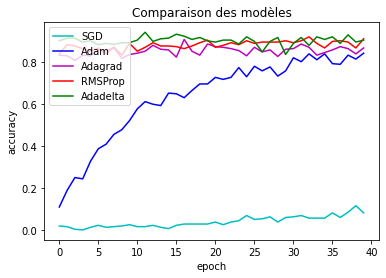

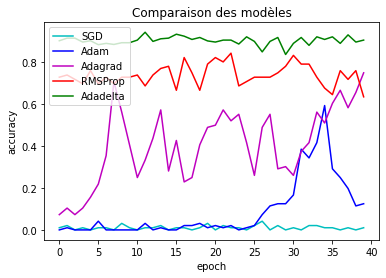

In [ ]:
# summarize history for accuracy
plt.plot(history_B2_rusgd.history['accuracy'], 'c-')
plt.plot(history_B2_ruadam.history['accuracy'], 'b-')
plt.plot(history_B2_ruadag.history['accuracy'], 'm-')
plt.plot(history_B2_rurms.history['accuracy'], 'r-')
plt.plot(history_B2_ruadad.history['accuracy'], 'g-')
plt.title('Comparaison des modèles')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['SGD', 'Adam', 'Adagrad', 'RMSProp', 'Adadelta'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(history_B2_rusgd.history['val_accuracy'], 'c-')
plt.plot(history_B2_ruadam.history['val_accuracy'], 'b-')
plt.plot(history_B2_ruadag.history['val_accuracy'], 'm-')
plt.plot(history_B2_rurms.history['val_accuracy'], 'r-')
plt.plot(history_B2_ruadad.history['val_accuracy'], 'g-')
plt.title('Comparaison des modèles')
plt.ylabel('val_accuracy')
plt.xlabel('epoch')
plt.legend(['SGD', 'Adam', 'Adagrad', 'RMSProp', 'Adadelta'], loc='upper left')
plt.show()

## EfficientNetB3

### SGD

In [ ]:
model_B3_ru.compile(loss="categorical_crossentropy", 
                optimizer=SGD(lr=0.0001, momentum=0.9), 
                metrics=["accuracy"])

start = time.time()

history_B3_rusgd = model_B3_ru.fit_generator(
      train_datagen,
      steps_per_epoch= np.ceil(400/batch_size),
      epochs=epochs,
      validation_data=test_datagen,
      validation_steps= np.ceil(100/batch_size),
      verbose=1,
      use_multiprocessing=False,
      workers=4)
print('Execution time: ', time.time()-start)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/40
10/10 [==============================] - 18s 712ms/step - loss: 5.3952 - accuracy: 0.0058 - val_loss: 4.7935 - val_accuracy: 0.0000e+00
Epoch 2/40
10/10 [==============================] - 5s 443ms/step - loss: 5.2982 - accuracy: 0.0139 - val_loss: 4.7871 - val_accuracy: 0.0208
Epoch 3/40
10/10 [==============================] - 5s 440ms/step - loss: 5.2014 - accuracy: 0.0092 - val_loss: 4.7756 - val_accuracy: 0.0208
Epoch 4/40
10/10 [==============================] - 5s 443ms/step - loss: 5.3837 - accuracy: 0.0000e+00 - val_loss: 4.7832 - val_accuracy: 0.0104
Epoch 5/40
10/10 [==============================] - 5s 441ms/step - loss: 5.2389 - accuracy: 0.0077 - val_loss: 4.8170 - val_accuracy: 0.0000e+00
Epoch 6/40
10/10 [==============================] - 5s 440ms/step - loss: 5.2414 - accuracy: 0.0138 - val_loss: 4.8263 - val_accuracy: 0.0104
Epoch 7/40
10/10 [==============================] - 5s 438ms/step - loss: 5.1660 - accuracy: 0.0113 - val_loss: 4.7772 - val_accuracy: 

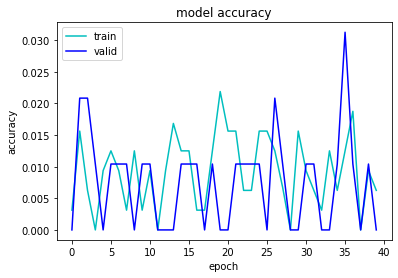

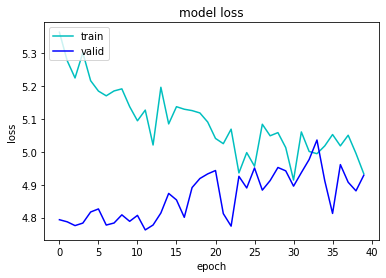

In [ ]:
# Summerize history for accuracy and loss
show_history(history_B3_rusgd)

### Adam

In [ ]:
model_B3_ru.compile(loss="categorical_crossentropy", 
                optimizer=Adam(learning_rate=0.0001), 
                metrics=["accuracy"])

start = time.time()

history_B3_ruadam = model_B3_ru.fit_generator(
      train_datagen,
      steps_per_epoch= np.ceil(400/batch_size),
      epochs=epochs,
      validation_data=test_datagen,
      validation_steps= np.ceil(100/batch_size),
      verbose=1,
      use_multiprocessing=False,
      workers=4)
print('Execution time: ', time.time()-start)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/40
10/10 [==============================] - 17s 721ms/step - loss: 5.0270 - accuracy: 0.0029 - val_loss: 4.9995 - val_accuracy: 0.0104
Epoch 2/40
10/10 [==============================] - 5s 442ms/step - loss: 5.0780 - accuracy: 0.0083 - val_loss: 4.9588 - val_accuracy: 0.0000e+00
Epoch 3/40
10/10 [==============================] - 5s 442ms/step - loss: 5.1653 - accuracy: 0.0060 - val_loss: 4.9317 - val_accuracy: 0.0208
Epoch 4/40
10/10 [==============================] - 5s 440ms/step - loss: 5.0175 - accuracy: 0.0095 - val_loss: 5.0201 - val_accuracy: 0.0000e+00
Epoch 5/40
10/10 [==============================] - 5s 442ms/step - loss: 5.0424 - accuracy: 0.0011 - val_loss: 4.9451 - val_accuracy: 0.0104
Epoch 6/40
10/10 [==============================] - 5s 442ms/step - loss: 5.1000 - accuracy: 0.0000e+00 - val_loss: 4.9701 - val_accuracy: 0.0208
Epoch 7/40
10/10 [==============================] - 5s 442ms/step - loss: 5.0449 - accuracy: 0.0092 - val_loss: 4.8989 - val_accuracy: 

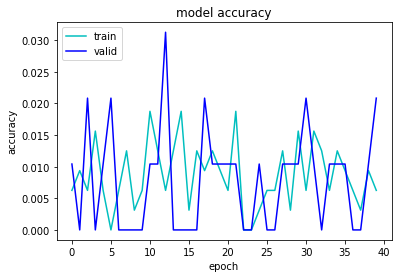

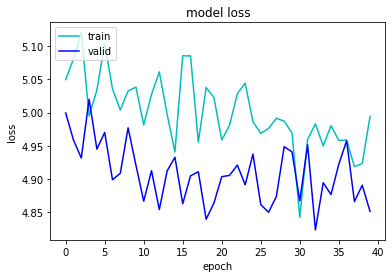

In [ ]:
# Summerize history for accuracy and loss
show_history(history_B3_ruadam)

### Adagrad

In [ ]:
model_B3_ru.compile(loss="categorical_crossentropy", 
                optimizer=Adagrad(learning_rate=0.001), 
                metrics=["accuracy"])

start = time.time()

history_B3_ruadag = model_B3_ru.fit_generator(
      train_datagen,
      steps_per_epoch= np.ceil(400/batch_size),
      epochs=epochs,
      validation_data=test_datagen,
      validation_steps= np.ceil(100/batch_size),
      verbose=1,
      use_multiprocessing=False,
      workers=4)
print('Execution time: ', time.time()-start)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/40
10/10 [==============================] - 18s 710ms/step - loss: 4.9519 - accuracy: 0.0114 - val_loss: 4.8066 - val_accuracy: 0.0104
Epoch 2/40
10/10 [==============================] - 5s 439ms/step - loss: 4.9565 - accuracy: 0.0130 - val_loss: 4.9302 - val_accuracy: 0.0104
Epoch 3/40
10/10 [==============================] - 5s 445ms/step - loss: 4.8425 - accuracy: 8.8384e-04 - val_loss: 4.9421 - val_accuracy: 0.0000e+00
Epoch 4/40
10/10 [==============================] - 5s 445ms/step - loss: 4.9453 - accuracy: 5.6818e-04 - val_loss: 4.8660 - val_accuracy: 0.0104
Epoch 5/40
10/10 [==============================] - 5s 443ms/step - loss: 4.9055 - accuracy: 0.0185 - val_loss: 4.9575 - val_accuracy: 0.0208
Epoch 6/40
10/10 [==============================] - 5s 444ms/step - loss: 4.9735 - accuracy: 0.0090 - val_loss: 4.8725 - val_accuracy: 0.0104
Epoch 7/40
10/10 [==============================] - 5s 441ms/step - loss: 4.8874 - accuracy: 0.0160 - val_loss: 4.8965 - val_accuracy: 

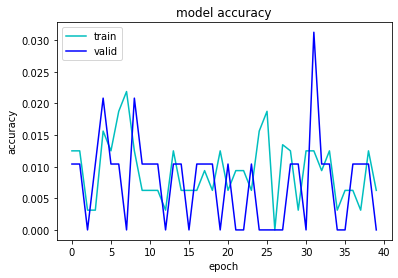

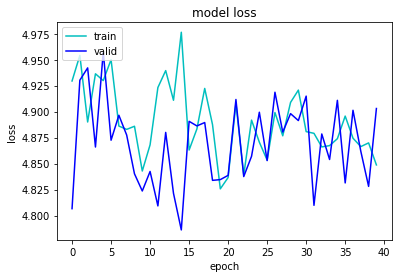

In [ ]:
# Summerize history for accuracy and loss
show_history(history_B3_ruadag)

### RMSprop

#### Avec callbacks

In [ ]:
model_B3_ru.compile(loss='categorical_crossentropy',
              optimizer=RMSprop(lr=2e-5),
              metrics=['accuracy'])

start = time.time()

history_B3_rurms = model_B3_ru.fit_generator(
      train_datagen,
      steps_per_epoch= np.ceil(400/batch_size),
      epochs=epochs,
      validation_data=test_datagen,
      validation_steps= np.ceil(100/batch_size),
      verbose=1,
      use_multiprocessing=False,
      workers=4,
      callbacks = [early_stopping_cd])
print('Execution time: ', time.time()-start)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/40
10/10 [==============================] - 29s 1s/step - loss: 1.3937 - accuracy: 0.6719 - val_loss: 1.4214 - val_accuracy: 0.6250
Epoch 2/40
10/10 [==============================] - 9s 838ms/step - loss: 1.2369 - accuracy: 0.7397 - val_loss: 1.7496 - val_accuracy: 0.6042
Epoch 3/40
10/10 [==============================] - 9s 845ms/step - loss: 1.3275 - accuracy: 0.7042 - val_loss: 1.5671 - val_accuracy: 0.5833
Epoch 4/40
10/10 [==============================] - 9s 856ms/step - loss: 1.4254 - accuracy: 0.6476 - val_loss: 1.3191 - val_accuracy: 0.6979
Epoch 5/40
10/10 [==============================] - 9s 865ms/step - loss: 1.2609 - accuracy: 0.7331 - val_loss: 1.3450 - val_accuracy: 0.6042
Epoch 6/40
10/10 [==============================] - 8s 858ms/step - loss: 1.3524 - accuracy: 0.6808 - val_loss: 1.6762 - val_accuracy: 0.5625
Epoch 7/40
10/10 [==============================] - 9s 861ms/step - loss: 1.5105 - accuracy: 0.6542 - val_loss: 1.1445 - val_accuracy: 0.7396
Epoch 8/

#### Sans callbacks

In [ ]:
model_B3_ru.compile(loss='categorical_crossentropy',
              optimizer=RMSprop(lr=2e-5),
              metrics=['accuracy'])

start = time.time()

history_B3_rurms = model_B3_ru.fit_generator(
      train_datagen,
      steps_per_epoch= np.ceil(400/batch_size),
      epochs=epochs,
      validation_data=test_datagen,
      validation_steps= np.ceil(100/batch_size),
      verbose=1,
      use_multiprocessing=False,
      workers=4)
print('Execution time: ', time.time()-start)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/40
10/10 [==============================] - 17s 712ms/step - loss: 4.8670 - accuracy: 0.0088 - val_loss: 4.8772 - val_accuracy: 0.0104
Epoch 2/40
10/10 [==============================] - 5s 443ms/step - loss: 4.8299 - accuracy: 0.0136 - val_loss: 4.8241 - val_accuracy: 0.0104
Epoch 3/40
10/10 [==============================] - 5s 449ms/step - loss: 4.7919 - accuracy: 0.0040 - val_loss: 4.8860 - val_accuracy: 0.0104
Epoch 4/40
10/10 [==============================] - 5s 443ms/step - loss: 4.8154 - accuracy: 0.0132 - val_loss: 4.8618 - val_accuracy: 0.0000e+00
Epoch 5/40
10/10 [==============================] - 5s 441ms/step - loss: 4.9214 - accuracy: 0.0039 - val_loss: 4.8626 - val_accuracy: 0.0000e+00
Epoch 6/40
10/10 [==============================] - 5s 441ms/step - loss: 4.8529 - accuracy: 0.0077 - val_loss: 4.8268 - val_accuracy: 0.0104
Epoch 7/40
10/10 [==============================] - 5s 441ms/step - loss: 4.8765 - accuracy: 0.0079 - val_loss: 4.8339 - val_accuracy: 0.02

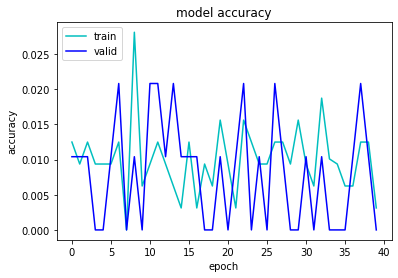

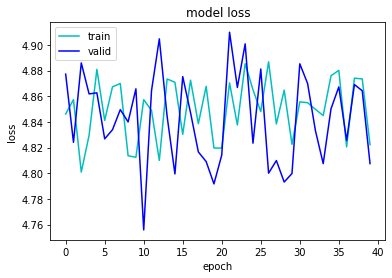

In [ ]:
# Summerize history for accuracy and loss
show_history(history_B3_rurms)

### Adadelta

#### Avec callbacks

In [ ]:
model_B3_ru.compile(loss='categorical_crossentropy',
              optimizer=Adadelta(learning_rate=0.001), 
                metrics=["accuracy"])

start = time.time()

history_B3_ruadad = model_B3_ru.fit_generator(
      train_datagen,
      steps_per_epoch= np.ceil(400/batch_size),
      epochs=epochs,
      validation_data=test_datagen,
      validation_steps= np.ceil(100/batch_size),
      verbose=1,
      use_multiprocessing=False,
      workers=4,
      callbacks = [early_stopping_cd])
print('Execution time: ', time.time()-start)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/40
10/10 [==============================] - 22s 1s/step - loss: 0.4316 - accuracy: 0.9069 - val_loss: 0.6161 - val_accuracy: 0.8333
Epoch 2/40
10/10 [==============================] - 9s 871ms/step - loss: 0.4616 - accuracy: 0.9027 - val_loss: 0.5814 - val_accuracy: 0.8229
Epoch 3/40
10/10 [==============================] - 9s 862ms/step - loss: 0.4735 - accuracy: 0.8955 - val_loss: 0.8055 - val_accuracy: 0.7500
Epoch 4/40
10/10 [==============================] - 9s 862ms/step - loss: 0.4257 - accuracy: 0.9140 - val_loss: 0.5121 - val_accuracy: 0.8438
Epoch 5/40
10/10 [==============================] - 9s 855ms/step - loss: 0.4855 - accuracy: 0.8986 - val_loss: 0.7086 - val_accuracy: 0.8229
Epoch 6/40
10/10 [==============================] - 9s 848ms/step - loss: 0.4434 - accuracy: 0.8901 - val_loss: 0.6313 - val_accuracy: 0.8646
Epoch 7/40
10/10 [==============================] - 9s 837ms/step - loss: 0.4451 - accuracy: 0.8743 - val_loss: 0.6014 - val_accuracy: 0.7812
Epoch 8/

#### Sans callbacks

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/40
10/10 [==============================] - 17s 710ms/step - loss: 4.8515 - accuracy: 0.0120 - val_loss: 4.8228 - val_accuracy: 0.0104
Epoch 2/40
10/10 [==============================] - 5s 441ms/step - loss: 4.8670 - accuracy: 0.0058 - val_loss: 4.8838 - val_accuracy: 0.0000e+00
Epoch 3/40
10/10 [==============================] - 5s 443ms/step - loss: 4.8414 - accuracy: 0.0084 - val_loss: 4.8678 - val_accuracy: 0.0104
Epoch 4/40
10/10 [==============================] - 5s 437ms/step - loss: 4.8620 - accuracy: 0.0160 - val_loss: 4.8257 - val_accuracy: 0.0104
Epoch 5/40
10/10 [==============================] - 5s 438ms/step - loss: 4.8015 - accuracy: 0.0144 - val_loss: 4.8395 - val_accuracy: 0.0000e+00
Epoch 6/40
10/10 [==============================] - 5s 443ms/step - loss: 4.8687 - accuracy: 0.0042 - val_loss: 4.8216 - val_accuracy: 0.0104
Epoch 7/40
10/10 [==============================] - 5s 440ms/step - loss: 4.8369 - accuracy: 0.0066 - val_loss: 4.8617 - val_accuracy: 0.01

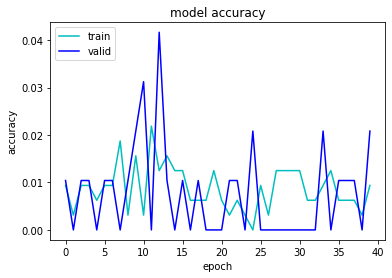

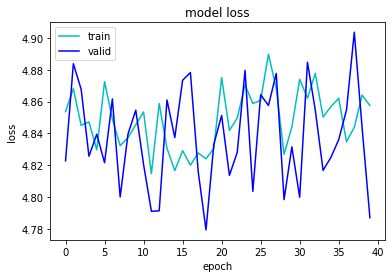

In [ ]:
model_B3_ru.compile(loss='categorical_crossentropy',
              optimizer=Adadelta(learning_rate=0.001), 
                metrics=["accuracy"])

start = time.time()

history_B3_ruadad = model_B3_ru.fit_generator(
      train_datagen,
      steps_per_epoch= np.ceil(400/batch_size),
      epochs=epochs,
      validation_data=test_datagen,
      validation_steps= np.ceil(100/batch_size),
      verbose=1,
      use_multiprocessing=False,
      workers=4)
print('Execution time: ', time.time()-start)

# Summerize history for accuracy and loss
show_history(history_B3_ruadad)

### Comparaison

In [ ]:
# summarize history for accuracy
plt.plot(history_B3_rusgd.history['accuracy'], 'c-')
plt.plot(history_B3_ruadam.history['accuracy'], 'b-')
plt.plot(history_B3_ruadag.history['accuracy'], 'm-')
plt.plot(history_B3_rurms.history['accuracy'], 'r-')
plt.plot(history_B3_ruadad.history['accuracy'], 'g-')
plt.title('Comparaison des modèles')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['SGD', 'Adam', 'Adagrad', 'RMSProp', 'Adadelta'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(history_B3_rusgd.history['val_accuracy'], 'c-')
plt.plot(history_B3_ruadam.history['val_accuracy'], 'b-')
plt.plot(history_B3_ruadag.history['val_accuracy'], 'm-')
plt.plot(history_B3_rurms.history['val_accuracy'], 'r-')
plt.plot(history_B3_ruadad.history['val_accuracy'], 'g-')
plt.title('Comparaison des modèles')
plt.ylabel('val_accuracy')
plt.xlabel('epoch')
plt.legend(['SGD', 'Adam', 'Adagrad', 'RMSProp', 'Adadelta'], loc='upper left')
plt.show()

## EfficientNetB4

### SGD

In [ ]:
model_B4_ru.compile(loss="categorical_crossentropy", 
                optimizer=SGD(lr=0.0001, momentum=0.9), 
                metrics=["accuracy"])

start = time.time()

history_B4_rusgd = model_B4_ru.fit_generator(
      train_datagen,
      steps_per_epoch= np.ceil(400/batch_size),
      epochs=epochs,
      validation_data=test_datagen,
      validation_steps= np.ceil(100/batch_size),
      verbose=1,
      use_multiprocessing=False,
      workers=4)
print('Execution time: ', time.time()-start)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/40
10/10 [==============================] - 29s 1s/step - loss: 5.2958 - accuracy: 0.0169 - val_loss: 4.7869 - val_accuracy: 0.0104
Epoch 2/40
10/10 [==============================] - 11s 1s/step - loss: 5.2571 - accuracy: 0.0264 - val_loss: 4.7777 - val_accuracy: 0.0000e+00
Epoch 3/40
10/10 [==============================] - 11s 1s/step - loss: 5.2689 - accuracy: 0.0000e+00 - val_loss: 4.8040 - val_accuracy: 0.0000e+00
Epoch 4/40
10/10 [==============================] - 11s 1s/step - loss: 5.2081 - accuracy: 0.0024 - val_loss: 4.7709 - val_accuracy: 0.0208
Epoch 5/40
10/10 [==============================] - 11s 1s/step - loss: 5.2825 - accuracy: 0.0081 - val_loss: 4.8624 - val_accuracy: 0.0000e+00
Epoch 6/40
10/10 [==============================] - 11s 1s/step - loss: 5.1836 - accuracy: 0.0085 - val_loss: 4.7911 - val_accuracy: 0.0104
Epoch 7/40
10/10 [==============================] - 11s 1s/step - loss: 5.2687 - accuracy: 0.0058 - val_loss: 4.8031 - val_accuracy: 0.0000e+00


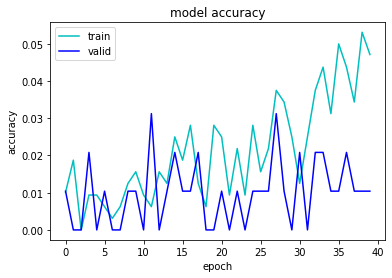

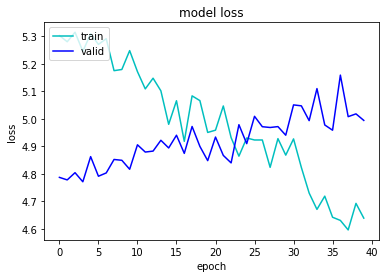

In [ ]:
# Summerize history for accuracy and loss
show_history(history_B4_rusgd)

### Adam

In [ ]:
model_B4_ru.compile(loss="categorical_crossentropy", 
                optimizer=Adam(learning_rate=0.0001), 
                metrics=["accuracy"])

start = time.time()

history_B4_ruadam = model_B4_ru.fit_generator(
      train_datagen,
      steps_per_epoch= np.ceil(400/batch_size),
      epochs=epochs,
      validation_data=test_datagen,
      validation_steps= np.ceil(100/batch_size),
      verbose=1,
      use_multiprocessing=False,
      workers=4)
print('Execution time: ', time.time()-start)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/40
10/10 [==============================] - 27s 1s/step - loss: 4.3947 - accuracy: 0.0413 - val_loss: 4.9983 - val_accuracy: 0.0208
Epoch 2/40
10/10 [==============================] - 11s 1s/step - loss: 4.2740 - accuracy: 0.0770 - val_loss: 5.0694 - val_accuracy: 0.0104
Epoch 3/40
10/10 [==============================] - 11s 1s/step - loss: 4.0424 - accuracy: 0.1211 - val_loss: 5.0946 - val_accuracy: 0.0312
Epoch 4/40
10/10 [==============================] - 11s 1s/step - loss: 3.6130 - accuracy: 0.2185 - val_loss: 4.9680 - val_accuracy: 0.0208
Epoch 5/40
10/10 [==============================] - 11s 1s/step - loss: 3.6176 - accuracy: 0.2223 - val_loss: 5.0230 - val_accuracy: 0.0312
Epoch 6/40
10/10 [==============================] - 11s 1s/step - loss: 3.2410 - accuracy: 0.2866 - val_loss: 4.9925 - val_accuracy: 0.0104
Epoch 7/40
10/10 [==============================] - 11s 1s/step - loss: 2.9591 - accuracy: 0.3136 - val_loss: 5.0390 - val_accuracy: 0.0104
Epoch 8/40
10/10 [==

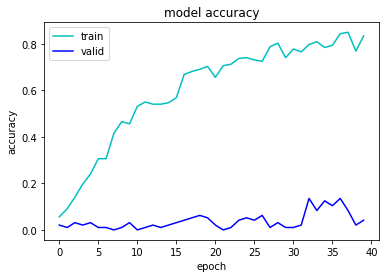

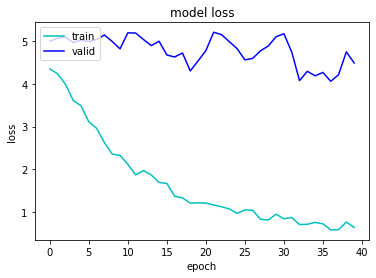

In [ ]:
# Summerize history for accuracy and loss
show_history(history_B4_ruadam)

### Adagrad

In [ ]:
model_B4_ru.compile(loss="categorical_crossentropy", 
                optimizer=Adagrad(learning_rate=0.001), 
                metrics=["accuracy"])

start = time.time()

history_B4_ruadag = model_B4_ru.fit_generator(
      train_datagen,
      steps_per_epoch= np.ceil(400/batch_size),
      epochs=epochs,
      validation_data=test_datagen,
      validation_steps= np.ceil(100/batch_size),
      verbose=1,
      use_multiprocessing=False,
      workers=4)
print('Execution time: ', time.time()-start)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/40
10/10 [==============================] - 27s 1s/step - loss: 0.6132 - accuracy: 0.8333 - val_loss: 4.0946 - val_accuracy: 0.0938
Epoch 2/40
10/10 [==============================] - 11s 1s/step - loss: 0.6393 - accuracy: 0.8209 - val_loss: 4.2559 - val_accuracy: 0.0833
Epoch 3/40
10/10 [==============================] - 11s 1s/step - loss: 0.7072 - accuracy: 0.7826 - val_loss: 3.7737 - val_accuracy: 0.1562
Epoch 4/40
10/10 [==============================] - 11s 1s/step - loss: 0.5858 - accuracy: 0.8464 - val_loss: 4.0350 - val_accuracy: 0.0833
Epoch 5/40
10/10 [==============================] - 11s 1s/step - loss: 0.5759 - accuracy: 0.8437 - val_loss: 4.0415 - val_accuracy: 0.1458
Epoch 6/40
10/10 [==============================] - 11s 1s/step - loss: 0.5218 - accuracy: 0.8628 - val_loss: 3.3082 - val_accuracy: 0.2188
Epoch 7/40
10/10 [==============================] - 11s 1s/step - loss: 0.6145 - accuracy: 0.8639 - val_loss: 4.7243 - val_accuracy: 0.0312
Epoch 8/40
10/10 [==

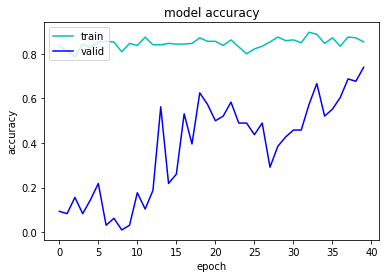

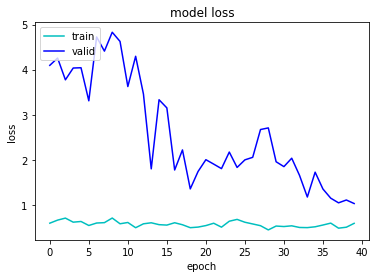

In [ ]:
# Summerize history for accuracy and loss
show_history(history_B4_ruadag)

### RMSprop

#### Avec callbacks

In [ ]:
model_B4_ru.compile(loss='categorical_crossentropy',
              optimizer=RMSprop(lr=2e-5),
              metrics=['accuracy'])

start = time.time()

history_B4_rurms = model_B4_ru.fit_generator(
      train_datagen,
      steps_per_epoch= np.ceil(400/batch_size),
      epochs=epochs,
      validation_data=test_datagen,
      validation_steps= np.ceil(100/batch_size),
      verbose=1,
      use_multiprocessing=False,
      workers=4,
      callbacks = [early_stopping_cd])
print('Execution time: ', time.time()-start)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/40
10/10 [==============================] - 38s 1s/step - loss: 5.2493 - accuracy: 0.0061 - val_loss: 4.7879 - val_accuracy: 0.0000e+00
Epoch 2/40
10/10 [==============================] - 11s 1s/step - loss: 5.2278 - accuracy: 0.0126 - val_loss: 4.7851 - val_accuracy: 0.0000e+00
Epoch 3/40
10/10 [==============================] - 11s 1s/step - loss: 5.3664 - accuracy: 0.0121 - val_loss: 4.7867 - val_accuracy: 0.0104
Epoch 4/40
10/10 [==============================] - 11s 1s/step - loss: 5.1363 - accuracy: 0.0100 - val_loss: 4.8188 - val_accuracy: 0.0000e+00
Epoch 5/40
10/10 [==============================] - 11s 1s/step - loss: 5.2087 - accuracy: 0.0170 - val_loss: 4.8137 - val_accuracy: 0.0000e+00
Epoch 6/40
10/10 [==============================] - 11s 1s/step - loss: 4.9921 - accuracy: 0.0079 - val_loss: 4.7854 - val_accuracy: 0.0208
Epoch 7/40
10/10 [==============================] - 11s 1s/step - loss: 5.0044 - accuracy: 0.0156 - val_loss: 4.8136 - val_accuracy: 0.0104
Epoc

#### Sans callbacks

In [ ]:
model_B4_ru.compile(loss='categorical_crossentropy',
              optimizer=RMSprop(lr=2e-5),
              metrics=['accuracy'])

start = time.time()

history_B4_rurms = model_B4_ru.fit_generator(
      train_datagen,
      steps_per_epoch= np.ceil(400/batch_size),
      epochs=epochs,
      validation_data=test_datagen,
      validation_steps= np.ceil(100/batch_size),
      verbose=1,
      use_multiprocessing=False,
      workers=4)
print('Execution time: ', time.time()-start)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/40
10/10 [==============================] - 37s 1s/step - loss: 3.0974 - accuracy: 0.3293 - val_loss: 4.8867 - val_accuracy: 0.0312
Epoch 2/40
10/10 [==============================] - 11s 1s/step - loss: 3.0560 - accuracy: 0.3331 - val_loss: 5.0915 - val_accuracy: 0.0104
Epoch 3/40
10/10 [==============================] - 11s 1s/step - loss: 3.0702 - accuracy: 0.3471 - val_loss: 4.9059 - val_accuracy: 0.0104
Epoch 4/40
10/10 [==============================] - 11s 1s/step - loss: 2.8762 - accuracy: 0.3583 - val_loss: 4.8377 - val_accuracy: 0.0000e+00
Epoch 5/40
10/10 [==============================] - 11s 1s/step - loss: 2.9021 - accuracy: 0.3597 - val_loss: 4.9835 - val_accuracy: 0.0000e+00
Epoch 6/40
10/10 [==============================] - 11s 1s/step - loss: 2.7271 - accuracy: 0.3683 - val_loss: 5.0319 - val_accuracy: 0.0104
Epoch 7/40
10/10 [==============================] - 11s 1s/step - loss: 2.6420 - accuracy: 0.4105 - val_loss: 5.0642 - val_accuracy: 0.0104
Epoch 8/40
1

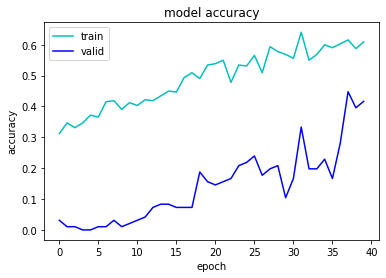

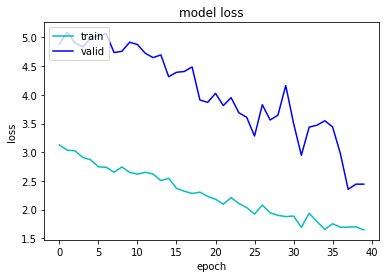

In [ ]:
# Summerize history for accuracy and loss
show_history(history_B4_rurms)

### Adadelta

#### Avec callbacks

In [ ]:
model_B4_ru.compile(loss='categorical_crossentropy',
              optimizer=Adadelta(learning_rate=0.001), 
                metrics=["accuracy"])

start = time.time()

history_B4_ruagad = model_B4_ru.fit_generator(
      train_datagen,
      steps_per_epoch= np.ceil(400/batch_size),
      epochs=epochs,
      validation_data=test_datagen,
      validation_steps= np.ceil(100/batch_size),
      verbose=1,
      use_multiprocessing=False,
      workers=4,
      callbacks = [early_stopping_cd])
print('Execution time: ', time.time()-start)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/40
10/10 [==============================] - 28s 1s/step - loss: 1.6791 - accuracy: 0.5989 - val_loss: 2.3845 - val_accuracy: 0.3958
Epoch 2/40
10/10 [==============================] - 11s 1s/step - loss: 1.6879 - accuracy: 0.5896 - val_loss: 2.1361 - val_accuracy: 0.5000
Epoch 3/40
10/10 [==============================] - 11s 1s/step - loss: 1.5822 - accuracy: 0.6044 - val_loss: 2.0467 - val_accuracy: 0.4792
Epoch 4/40
10/10 [==============================] - 11s 1s/step - loss: 1.6433 - accuracy: 0.5857 - val_loss: 1.8107 - val_accuracy: 0.5521
Epoch 5/40
10/10 [==============================] - 11s 1s/step - loss: 1.5186 - accuracy: 0.6883 - val_loss: 1.8699 - val_accuracy: 0.5625
Epoch 6/40
10/10 [==============================] - 11s 1s/step - loss: 1.6296 - accuracy: 0.6514 - val_loss: 1.8071 - val_accuracy: 0.5208
Epoch 7/40
10/10 [==============================] - 11s 1s/step - loss: 1.6203 - accuracy: 0.6511 - val_loss: 1.6460 - val_accuracy: 0.5729
Epoch 8/40
10/10 [==

#### Sans callbacks

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/40
10/10 [==============================] - 28s 1s/step - loss: 1.5922 - accuracy: 0.6233 - val_loss: 1.7619 - val_accuracy: 0.6146
Epoch 2/40
10/10 [==============================] - 11s 1s/step - loss: 1.5794 - accuracy: 0.6472 - val_loss: 1.4976 - val_accuracy: 0.6458
Epoch 3/40
10/10 [==============================] - 11s 1s/step - loss: 1.4749 - accuracy: 0.6524 - val_loss: 1.7067 - val_accuracy: 0.5938
Epoch 4/40
10/10 [==============================] - 11s 1s/step - loss: 1.4654 - accuracy: 0.6699 - val_loss: 1.6106 - val_accuracy: 0.5938
Epoch 5/40
10/10 [==============================] - 11s 1s/step - loss: 1.5282 - accuracy: 0.6388 - val_loss: 1.7023 - val_accuracy: 0.6250
Epoch 6/40
10/10 [==============================] - 11s 1s/step - loss: 1.5509 - accuracy: 0.6560 - val_loss: 1.6093 - val_accuracy: 0.6354
Epoch 7/40
10/10 [==============================] - 11s 1s/step - loss: 1.4981 - accuracy: 0.6406 - val_loss: 1.7260 - val_accuracy: 0.5000
Epoch 8/40
10/10 [==

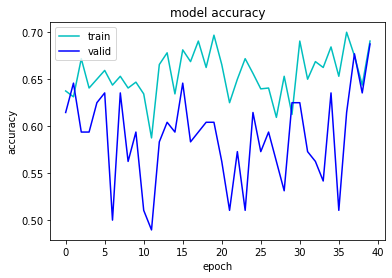

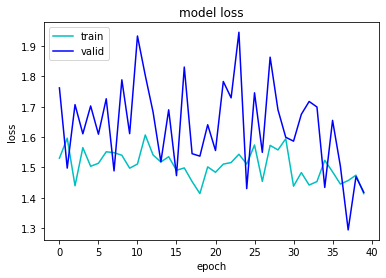

In [ ]:
model_B4_ru.compile(loss='categorical_crossentropy',
              optimizer=Adadelta(learning_rate=0.001), 
                metrics=["accuracy"])

start = time.time()

history_B4_ruadad = model_B4_ru.fit_generator(
      train_datagen,
      steps_per_epoch= np.ceil(400/batch_size),
      epochs=epochs,
      validation_data=test_datagen,
      validation_steps= np.ceil(100/batch_size),
      verbose=1,
      use_multiprocessing=False,
      workers=4)
print('Execution time: ', time.time()-start)

# Summerize history for accuracy and loss
show_history(history_B4_ruadad)

### Comparaison

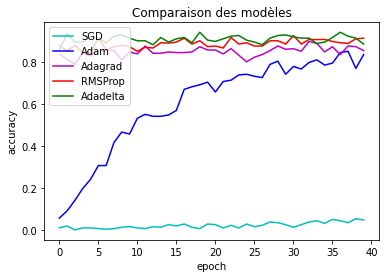

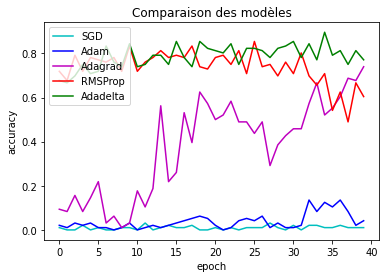

In [ ]:
# summarize history for accuracy
plt.plot(history_B4_rusgd.history['accuracy'], 'c-')
plt.plot(history_B4_ruadam.history['accuracy'], 'b-')
plt.plot(history_B4_ruadag.history['accuracy'], 'm-')
plt.plot(history_B4_rurms.history['accuracy'], 'r-')
plt.plot(history_B4_ruadad.history['accuracy'], 'g-')
plt.title('Comparaison des modèles')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['SGD', 'Adam', 'Adagrad', 'RMSProp', 'Adadelta'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(history_B4_rusgd.history['val_accuracy'], 'c-')
plt.plot(history_B4_ruadam.history['val_accuracy'], 'b-')
plt.plot(history_B4_ruadag.history['val_accuracy'], 'm-')
plt.plot(history_B4_rurms.history['val_accuracy'], 'r-')
plt.plot(history_B4_ruadad.history['val_accuracy'], 'g-')
plt.title('Comparaison des modèles')
plt.ylabel('val_accuracy')
plt.xlabel('epoch')
plt.legend(['SGD', 'Adam', 'Adagrad', 'RMSProp', 'Adadelta'], loc='upper left')
plt.show()

## EfficientNetB5

In [ ]:
''''model_B5.compile(loss='categorical_crossentropy',
              optimizer=RMSprop(lr=2e-5),
              metrics=['accuracy'])

start = time.time()

history_B5 = model_B5.fit_generator(
      train_datagen,
      steps_per_epoch= np.ceil(400/batch_size),
      epochs=epochs,
      validation_data=test_datagen,
      validation_steps= np.ceil(100/batch_size),
      verbose=1,
      use_multiprocessing=False)#,
      #workers=4)
print('Execution time: ', time.time()-start)'''

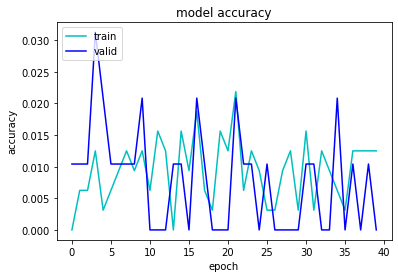

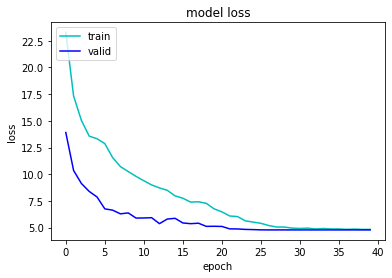

In [ ]:
# Summerize history for accuracy and loss
show_history(history_B5)

# #EP=40/BS=80

In [ ]:
batch_size = 80
epochs = 40 
verbose = 1

## EfficientNetB0

### Adadelta

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/60
5/5 [==============================] - 11s 813ms/step - loss: 4.8682 - accuracy: 0.0077 - val_loss: 4.8108 - val_accuracy: 0.0312
Epoch 2/60
5/5 [==============================] - 2s 479ms/step - loss: 4.8641 - accuracy: 0.0155 - val_loss: 987142272.0000 - val_accuracy: 0.0000e+00
Epoch 3/60
5/5 [==============================] - 2s 480ms/step - loss: 4.8247 - accuracy: 0.0072 - val_loss: 4.8199 - val_accuracy: 0.0312
Epoch 4/60
5/5 [==============================] - 2s 473ms/step - loss: 4.8270 - accuracy: 0.0390 - val_loss: 4.7838 - val_accuracy: 0.0000e+00
Epoch 5/60
5/5 [==============================] - 2s 480ms/step - loss: 4.8674 - accuracy: 0.0000e+00 - val_loss: 4.7995 - val_accuracy: 0.0156
Epoch 6/60
5/5 [==============================] - 2s 477ms/step - loss: 4.8286 - accuracy: 0.0034 - val_loss: 4.9050 - val_accuracy: 0.0156
Epoch 7/60
5/5 [==============================] - 2s 472ms/step - loss: 4.8566 - accuracy: 0.0077 - val_loss: 4.9084 - val_accuracy: 0.0000

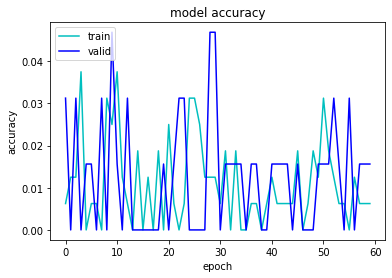

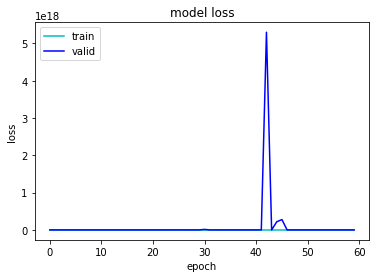

In [ ]:
model_B0_ru.compile(loss='categorical_crossentropy',
              optimizer=Adadelta(learning_rate=0.001), 
                metrics=["accuracy"])

start = time.time()

history_B0_ruadad = model_B0_ru.fit_generator(
      train_datagen,
      steps_per_epoch= np.ceil(400/batch_size),
      epochs=epochs,
      validation_data=test_datagen,
      validation_steps= np.ceil(100/batch_size),
      verbose=verbose,
      use_multiprocessing=False)
print('Execution time: ', time.time()-start)

# Summerize history for accuracy and loss
show_history(history_B0_ruadad)

### RMSprop

In [ ]:
model_B0_ru.compile(loss='categorical_crossentropy',
              optimizer=RMSprop(lr=2e-5),
              metrics=['accuracy'])

start = time.time()

history_B0_rurms = model_B0_ru.fit_generator(
      train_datagen,
      steps_per_epoch= np.ceil(400/batch_size),
      epochs=epochs,
      validation_data=test_datagen,
      validation_steps= np.ceil(100/batch_size),
      verbose=verbose,
      use_multiprocessing=False)
print('Execution time: ', time.time()-start)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/60
5/5 [==============================] - 16s 798ms/step - loss: 4.7655 - accuracy: 0.0129 - val_loss: 4.8416 - val_accuracy: 0.0312
Epoch 2/60
5/5 [==============================] - 2s 488ms/step - loss: 4.8282 - accuracy: 0.0034 - val_loss: 4.7272 - val_accuracy: 0.0156
Epoch 3/60
5/5 [==============================] - 2s 490ms/step - loss: 4.7592 - accuracy: 0.0098 - val_loss: 884219.2500 - val_accuracy: 0.0000e+00
Epoch 4/60
5/5 [==============================] - 2s 496ms/step - loss: 4.8064 - accuracy: 0.0077 - val_loss: 16755228409856.0000 - val_accuracy: 0.0000e+00
Epoch 5/60
5/5 [==============================] - 2s 491ms/step - loss: 4.7867 - accuracy: 0.0021 - val_loss: 4.8172 - val_accuracy: 0.0312
Epoch 6/60
5/5 [==============================] - 2s 490ms/step - loss: 4.7522 - accuracy: 0.0106 - val_loss: 134463226406494011392.0000 - val_accuracy: 0.0469
Epoch 7/60
5/5 [==============================] - 2s 488ms/step - loss: 4.7727 - accuracy: 0.0034 - val_loss: 4.7

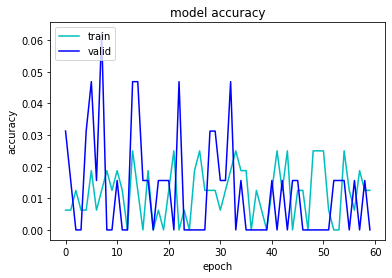

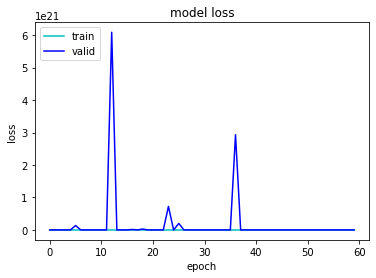

In [ ]:
# Summerize history for accuracy and loss
show_history(history_B0_rurms)

## EfficientNetB1

### Adadelta

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/40
5/5 [==============================] - 18s 2s/step - loss: 5.4700 - accuracy: 0.0000e+00 - val_loss: 4.7845 - val_accuracy: 0.0312
Epoch 2/40
5/5 [==============================] - 8s 1s/step - loss: 5.3750 - accuracy: 0.0000e+00 - val_loss: 4.8011 - val_accuracy: 0.0000e+00
Epoch 3/40
5/5 [==============================] - 6s 1s/step - loss: 5.3963 - accuracy: 0.0000e+00 - val_loss: 4.7949 - val_accuracy: 0.0156
Epoch 4/40
5/5 [==============================] - 5s 744ms/step - loss: 5.3370 - accuracy: 0.0129 - val_loss: 4.7907 - val_accuracy: 0.0000e+00
Epoch 5/40
5/5 [==============================] - 6s 1s/step - loss: 5.3619 - accuracy: 0.0205 - val_loss: 4.7934 - val_accuracy: 0.0000e+00
Epoch 6/40
5/5 [==============================] - 6s 1s/step - loss: 5.3715 - accuracy: 0.0000e+00 - val_loss: 4.8027 - val_accuracy: 0.0000e+00
Epoch 7/40
5/5 [==============================] - 6s 1s/step - loss: 5.3397 - accuracy: 0.0155 - val_loss: 4.7820 - val_accuracy: 0.0312
Epoch

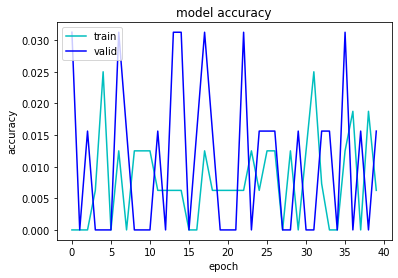

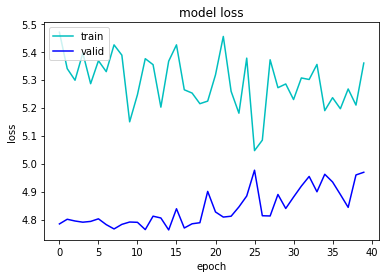

In [ ]:
model_B1_ru.compile(loss='categorical_crossentropy',
              optimizer=Adadelta(learning_rate=0.001), 
                metrics=["accuracy"])

start = time.time()

history_B1_ruadad = model_B1_ru.fit_generator(
      train_datagen,
      steps_per_epoch= np.ceil(400/batch_size),
      epochs=epochs,
      validation_data=test_datagen,
      validation_steps= np.ceil(100/batch_size),
      verbose=verbose,
      use_multiprocessing=False)
print('Execution time: ', time.time()-start)

# Summerize history for accuracy and loss
show_history(history_B1_ruadad)

### RMSprop

In [ ]:
model_B1_ru.compile(loss='categorical_crossentropy',
              optimizer=RMSprop(lr=2e-5),
              metrics=['accuracy'])

start = time.time()

history_B1_rurms = model_B1_ru.fit_generator(
      train_datagen,
      steps_per_epoch= np.ceil(400/batch_size),
      epochs=epochs,
      validation_data=test_datagen,
      validation_steps= np.ceil(100/batch_size),
      verbose=verbose,
      use_multiprocessing=False)
print('Execution time: ', time.time()-start)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/40
5/5 [==============================] - 22s 1s/step - loss: 5.2052 - accuracy: 0.0000e+00 - val_loss: 4.9990 - val_accuracy: 0.0000e+00
Epoch 2/40
5/5 [==============================] - 5s 874ms/step - loss: 5.1967 - accuracy: 0.0098 - val_loss: 4.8918 - val_accuracy: 0.0000e+00
Epoch 3/40
5/5 [==============================] - 4s 878ms/step - loss: 5.1275 - accuracy: 0.0162 - val_loss: 4.9586 - val_accuracy: 0.0000e+00
Epoch 4/40
5/5 [==============================] - 3s 661ms/step - loss: 5.1416 - accuracy: 0.0387 - val_loss: 4.8573 - val_accuracy: 0.0156
Epoch 5/40
5/5 [==============================] - 4s 666ms/step - loss: 5.1738 - accuracy: 0.0171 - val_loss: 4.9694 - val_accuracy: 0.0000e+00
Epoch 6/40
5/5 [==============================] - 4s 779ms/step - loss: 5.1266 - accuracy: 0.0106 - val_loss: 4.9351 - val_accuracy: 0.0469
Epoch 7/40
5/5 [==============================] - 4s 659ms/step - loss: 5.0267 - accuracy: 0.0140 - val_loss: 5.0529 - val_accuracy: 0.0000e+0

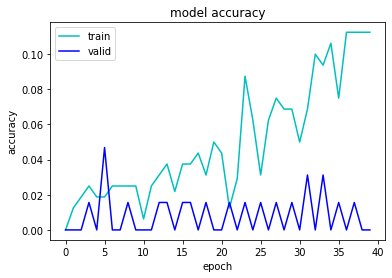

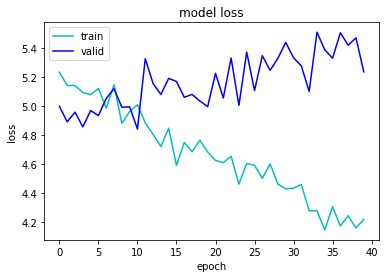

In [ ]:
# Summerize history for accuracy and loss
show_history(history_B1_rurms)

## EfficientNetB2


### Adadelta

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/40
5/5 [==============================] - 16s 1s/step - loss: 5.2761 - accuracy: 0.0000e+00 - val_loss: 4.7953 - val_accuracy: 0.0156
Epoch 2/40
5/5 [==============================] - 3s 679ms/step - loss: 5.2798 - accuracy: 0.0077 - val_loss: 4.7953 - val_accuracy: 0.0156
Epoch 3/40
5/5 [==============================] - 3s 686ms/step - loss: 5.3912 - accuracy: 0.0068 - val_loss: 4.8027 - val_accuracy: 0.0000e+00
Epoch 4/40
5/5 [==============================] - 4s 674ms/step - loss: 5.4663 - accuracy: 0.0051 - val_loss: 4.7990 - val_accuracy: 0.0156
Epoch 5/40
5/5 [==============================] - 3s 676ms/step - loss: 5.4107 - accuracy: 0.0034 - val_loss: 4.7968 - val_accuracy: 0.0000e+00
Epoch 6/40
5/5 [==============================] - 3s 693ms/step - loss: 5.1745 - accuracy: 0.0077 - val_loss: 4.8029 - val_accuracy: 0.0000e+00
Epoch 7/40
5/5 [==============================] - 3s 685ms/step - loss: 5.3439 - accuracy: 0.0051 - val_loss: 4.8003 - val_accuracy: 0.0156
Epoch 

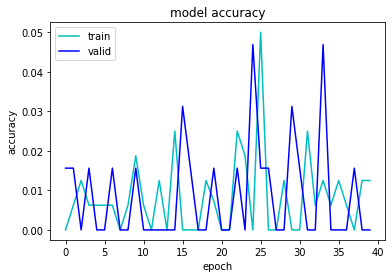

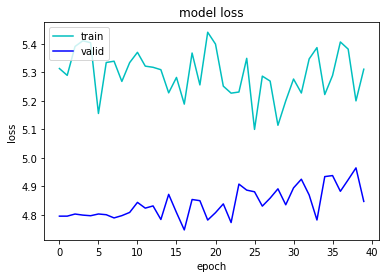

In [ ]:
model_B2_ru.compile(loss='categorical_crossentropy',
              optimizer=Adadelta(learning_rate=0.001), 
                metrics=["accuracy"])

start = time.time()

history_B2_ruadad = model_B2_ru.fit_generator(
      train_datagen,
      steps_per_epoch= np.ceil(400/batch_size),
      epochs=epochs,
      validation_data=test_datagen,
      validation_steps= np.ceil(100/batch_size),
      verbose=verbose,
      use_multiprocessing=False)
print('Execution time: ', time.time()-start)

# Summerize history for accuracy and loss
show_history(history_B2_ruadad)

### RMSprop

In [ ]:
model_B2_ru.compile(loss='categorical_crossentropy',
              optimizer=RMSprop(lr=2e-5),
              metrics=['accuracy'])

start = time.time()

history_B2_rurms = model_B2_ru.fit_generator(
      train_datagen,
      steps_per_epoch= np.ceil(400/batch_size),
      epochs=epochs,
      validation_data=test_datagen,
      validation_steps= np.ceil(100/batch_size),
      verbose=verbose,
      use_multiprocessing=False)
print('Execution time: ', time.time()-start)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/40
5/5 [==============================] - 22s 1s/step - loss: 5.1877 - accuracy: 0.0132 - val_loss: 4.9346 - val_accuracy: 0.0156
Epoch 2/40
5/5 [==============================] - 5s 869ms/step - loss: 5.1065 - accuracy: 0.0206 - val_loss: 4.9461 - val_accuracy: 0.0000e+00
Epoch 3/40
5/5 [==============================] - 3s 681ms/step - loss: 5.2232 - accuracy: 0.0150 - val_loss: 4.8811 - val_accuracy: 0.0156
Epoch 4/40
5/5 [==============================] - 3s 691ms/step - loss: 5.1581 - accuracy: 0.0051 - val_loss: 4.9530 - val_accuracy: 0.0156
Epoch 5/40
5/5 [==============================] - 3s 692ms/step - loss: 5.0522 - accuracy: 0.0230 - val_loss: 4.8889 - val_accuracy: 0.0469
Epoch 6/40
5/5 [==============================] - 3s 701ms/step - loss: 5.1410 - accuracy: 0.0021 - val_loss: 4.8875 - val_accuracy: 0.0000e+00
Epoch 7/40
5/5 [==============================] - 4s 690ms/step - loss: 4.7465 - accuracy: 0.0533 - val_loss: 5.0065 - val_accuracy: 0.0000e+00
Epoch 8/40

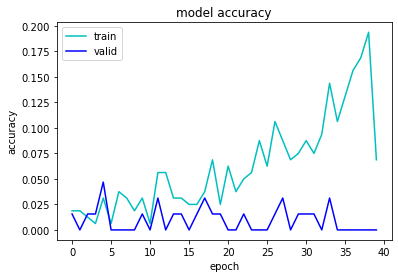

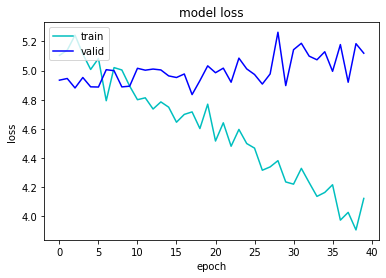

In [ ]:
# Summerize history for accuracy and loss
show_history(history_B2_rurms)

## EfficientNetB3

### Adadelta

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/40
5/5 [==============================] - 19s 1s/step - loss: 5.4020 - accuracy: 0.0000e+00 - val_loss: 4.7930 - val_accuracy: 0.0000e+00
Epoch 2/40
5/5 [==============================] - 4s 861ms/step - loss: 5.3564 - accuracy: 0.0034 - val_loss: 4.7888 - val_accuracy: 0.0000e+00
Epoch 3/40
5/5 [==============================] - 4s 879ms/step - loss: 5.6151 - accuracy: 0.0077 - val_loss: 4.7973 - val_accuracy: 0.0156
Epoch 4/40
5/5 [==============================] - 4s 856ms/step - loss: 5.3738 - accuracy: 0.0000e+00 - val_loss: 4.7729 - val_accuracy: 0.0000e+00
Epoch 5/40
5/5 [==============================] - 5s 939ms/step - loss: 5.2012 - accuracy: 0.0024 - val_loss: 4.7857 - val_accuracy: 0.0156
Epoch 6/40
5/5 [==============================] - 4s 862ms/step - loss: 5.3854 - accuracy: 0.0279 - val_loss: 4.7909 - val_accuracy: 0.0000e+00
Epoch 7/40
5/5 [==============================] - 4s 869ms/step - loss: 5.3322 - accuracy: 0.0150 - val_loss: 4.8098 - val_accuracy: 0.000

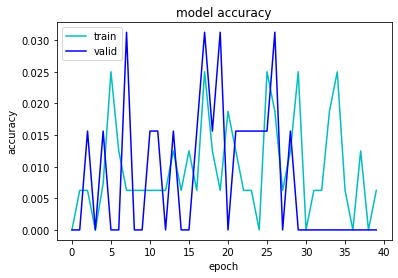

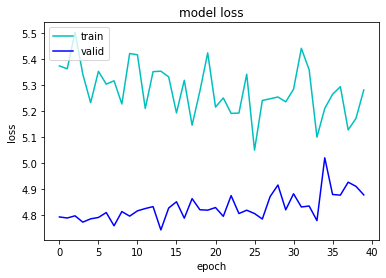

In [ ]:
model_B3_ru.compile(loss='categorical_crossentropy',
              optimizer=Adadelta(learning_rate=0.001), 
                metrics=["accuracy"])

start = time.time()

history_B3_ruadad = model_B3_ru.fit_generator(
      train_datagen,
      steps_per_epoch= np.ceil(400/batch_size),
      epochs=epochs,
      validation_data=test_datagen,
      validation_steps= np.ceil(100/batch_size),
      verbose=verbose,
      use_multiprocessing=False)
print('Execution time: ', time.time()-start)

# Summerize history for accuracy and loss
show_history(history_B3_ruadad)

### RMSprop

In [ ]:
model_B3_ru.compile(loss='categorical_crossentropy',
              optimizer=RMSprop(lr=2e-5),
              metrics=['accuracy'])

start = time.time()

history_B3_rurms = model_B3_ru.fit_generator(
      train_datagen,
      steps_per_epoch= np.ceil(400/batch_size),
      epochs=epochs,
      validation_data=test_datagen,
      validation_steps= np.ceil(100/batch_size),
      verbose=verbose,
      use_multiprocessing=False)
print('Execution time: ', time.time()-start)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/40
5/5 [==============================] - 26s 1s/step - loss: 4.9164 - accuracy: 0.0021 - val_loss: 4.9291 - val_accuracy: 0.0000e+00
Epoch 2/40
5/5 [==============================] - 4s 868ms/step - loss: 5.1991 - accuracy: 0.0282 - val_loss: 4.9084 - val_accuracy: 0.0000e+00
Epoch 3/40
5/5 [==============================] - 4s 879ms/step - loss: 5.2674 - accuracy: 0.0129 - val_loss: 4.9245 - val_accuracy: 0.0000e+00
Epoch 4/40
5/5 [==============================] - 4s 872ms/step - loss: 5.1736 - accuracy: 0.0331 - val_loss: 4.9513 - val_accuracy: 0.0000e+00
Epoch 5/40
5/5 [==============================] - 4s 871ms/step - loss: 4.9240 - accuracy: 0.0207 - val_loss: 4.8166 - val_accuracy: 0.0000e+00
Epoch 6/40
5/5 [==============================] - 4s 862ms/step - loss: 4.9288 - accuracy: 0.0098 - val_loss: 4.9269 - val_accuracy: 0.0156
Epoch 7/40
5/5 [==============================] - 4s 879ms/step - loss: 5.0843 - accuracy: 0.0085 - val_loss: 4.8772 - val_accuracy: 0.0312
Ep

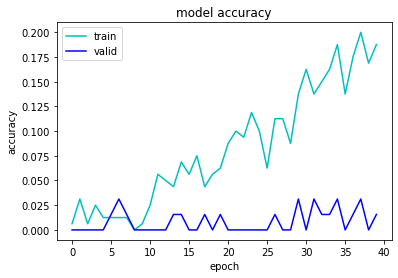

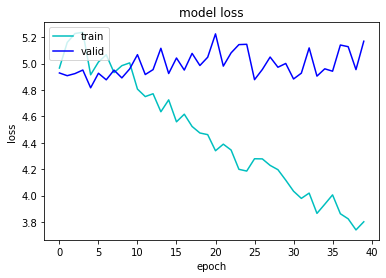

In [ ]:
# Summerize history for accuracy and loss
show_history(history_B3_rurms)

## EfficientNetB4

### Adadelta

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/40
5/5 [==============================] - 22s 2s/step - loss: 5.2041 - accuracy: 0.0258 - val_loss: 4.8196 - val_accuracy: 0.0000e+00
Epoch 2/40
5/5 [==============================] - 5s 1s/step - loss: 5.3240 - accuracy: 0.0000e+00 - val_loss: 4.8023 - val_accuracy: 0.0000e+00
Epoch 3/40
5/5 [==============================] - 5s 1s/step - loss: 5.3708 - accuracy: 0.0000e+00 - val_loss: 4.7663 - val_accuracy: 0.0000e+00
Epoch 4/40
5/5 [==============================] - 6s 1s/step - loss: 5.3992 - accuracy: 0.0145 - val_loss: 4.7902 - val_accuracy: 0.0156
Epoch 5/40
5/5 [==============================] - 6s 1s/step - loss: 5.4346 - accuracy: 0.0000e+00 - val_loss: 4.7960 - val_accuracy: 0.0000e+00
Epoch 6/40
5/5 [==============================] - 6s 1s/step - loss: 5.2000 - accuracy: 0.0000e+00 - val_loss: 4.7909 - val_accuracy: 0.0312
Epoch 7/40
5/5 [==============================] - 6s 1s/step - loss: 5.4080 - accuracy: 0.0000e+00 - val_loss: 4.7922 - val_accuracy: 0.0000e+00


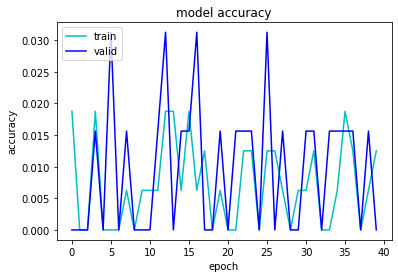

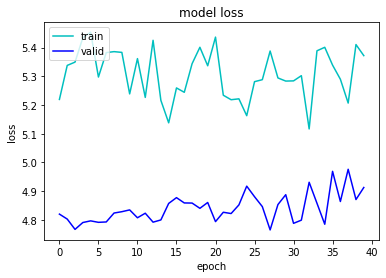

In [ ]:
model_B4_ru.compile(loss='categorical_crossentropy',
              optimizer=Adadelta(learning_rate=0.001), 
                metrics=["accuracy"])

start = time.time()

history_B4_ruadad = model_B4_ru.fit_generator(
      train_datagen,
      steps_per_epoch= np.ceil(400/batch_size),
      epochs=epochs,
      validation_data=test_datagen,
      validation_steps= np.ceil(100/batch_size),
      verbose=verbose,
      use_multiprocessing=False)
print('Execution time: ', time.time()-start)

# Summerize history for accuracy and loss
show_history(history_B4_ruadad)

### RMSprop

In [ ]:
model_B4_ru.compile(loss='categorical_crossentropy',
              optimizer=RMSprop(lr=2e-5),
              metrics=['accuracy'])

start = time.time()

history_B4_rurms = model_B4_ru.fit_generator(
      train_datagen,
      steps_per_epoch= np.ceil(400/batch_size),
      epochs=epochs,
      validation_data=test_datagen,
      validation_steps= np.ceil(100/batch_size),
      verbose=verbose,
      use_multiprocessing=False)
print('Execution time: ', time.time()-start)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/40
5/5 [==============================] - 32s 2s/step - loss: 5.3311 - accuracy: 0.0000e+00 - val_loss: 4.8166 - val_accuracy: 0.0000e+00
Epoch 2/40
5/5 [==============================] - 5s 1s/step - loss: 5.0816 - accuracy: 0.0055 - val_loss: 4.8867 - val_accuracy: 0.0000e+00
Epoch 3/40
5/5 [==============================] - 6s 1s/step - loss: 5.1450 - accuracy: 0.0051 - val_loss: 4.9219 - val_accuracy: 0.0156
Epoch 4/40
5/5 [==============================] - 6s 1s/step - loss: 5.3453 - accuracy: 0.0000e+00 - val_loss: 4.9011 - val_accuracy: 0.0156
Epoch 5/40
5/5 [==============================] - 6s 1s/step - loss: 4.9929 - accuracy: 0.0183 - val_loss: 4.8430 - val_accuracy: 0.0000e+00
Epoch 6/40
5/5 [==============================] - 6s 1s/step - loss: 5.1587 - accuracy: 0.0051 - val_loss: 4.9228 - val_accuracy: 0.0156
Epoch 7/40
5/5 [==============================] - 6s 1s/step - loss: 5.0721 - accuracy: 0.0076 - val_loss: 4.8699 - val_accuracy: 0.0000e+00
Epoch 8/40
5/5 [

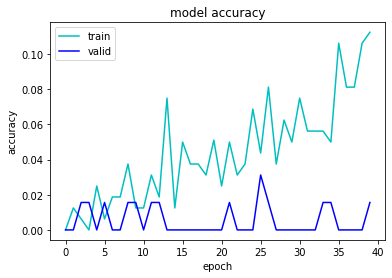

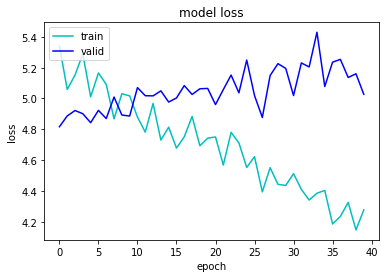

In [ ]:
# Summerize history for accuracy and loss
show_history(history_B4_rurms)

# #EP=80/BS=40

In [ ]:
verbose = 1
epochs = 80
batch_size = 40

## EfficientNetB3

### Adam

In [ ]:
model_B3_ru.compile(loss="categorical_crossentropy", 
                optimizer=Adam(learning_rate=0.0001), 
                metrics=["accuracy"])

start = time.time()

history_B3_ruadam = model_B3_ru.fit_generator(
      train_datagen,
      steps_per_epoch= np.ceil(400/batch_size),
      epochs=epochs,
      validation_data=test_datagen,
      validation_steps= np.ceil(100/batch_size),
      verbose=verbose,
      callbacks = [reducelr])
print('Execution time: ', time.time()-start)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/80
10/10 [==============================] - 109s 10s/step - loss: 4.1449 - accuracy: 0.1674 - val_loss: 4.7984 - val_accuracy: 0.0000e+00
Epoch 2/80
10/10 [==============================] - 104s 11s/step - loss: 3.8765 - accuracy: 0.1833 - val_loss: 4.8054 - val_accuracy: 0.0104
Epoch 3/80
10/10 [==============================] - 100s 10s/step - loss: 3.6841 - accuracy: 0.1674 - val_loss: 4.7734 - val_accuracy: 0.0208
Epoch 4/80
10/10 [==============================] - 98s 10s/step - loss: 3.1880 - accuracy: 0.3143 - val_loss: 4.8214 - val_accuracy: 0.0000e+00
Epoch 5/80
10/10 [==============================] - 95s 10s/step - loss: 2.8227 - accuracy: 0.3879 - val_loss: 4.8280 - val_accuracy: 0.0000e+00
Epoch 6/80
10/10 [==============================] - 79s 8s/step - loss: 2.4417 - accuracy: 0.4499 - val_loss: 4.7880 - val_accuracy: 0.0104
Epoch 7/80
10/10 [==============================] - 83s 8s/step - loss: 2.3371 - accuracy: 0.4992 - val_loss: 4.8306 - val_accuracy: 0.0000e

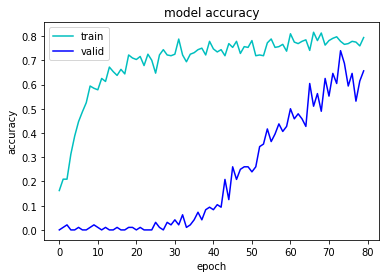

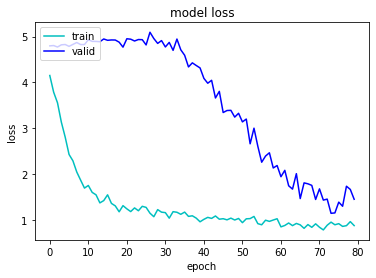

In [ ]:
# Summerize history for accuracy and loss
show_history(history_B3_ruadam)

### Adadelta

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/60
10/10 [==============================] - 22s 1s/step - loss: 1.8831 - accuracy: 0.5980 - val_loss: 4.1952 - val_accuracy: 0.1042
Epoch 2/60
10/10 [==============================] - 8s 836ms/step - loss: 1.9520 - accuracy: 0.5904 - val_loss: 3.6359 - val_accuracy: 0.2396
Epoch 3/60
10/10 [==============================] - 8s 840ms/step - loss: 1.9214 - accuracy: 0.5996 - val_loss: 3.6535 - val_accuracy: 0.1875
Epoch 4/60
10/10 [==============================] - 8s 837ms/step - loss: 1.8662 - accuracy: 0.5757 - val_loss: 3.1559 - val_accuracy: 0.2604
Epoch 5/60
10/10 [==============================] - 8s 831ms/step - loss: 2.0169 - accuracy: 0.5282 - val_loss: 2.9856 - val_accuracy: 0.2917
Epoch 6/60
10/10 [==============================] - 8s 833ms/step - loss: 1.9484 - accuracy: 0.5629 - val_loss: 3.1085 - val_accuracy: 0.3021
Epoch 7/60
10/10 [==============================] - 8s 831ms/step - loss: 1.9996 - accuracy: 0.5867 - val_loss: 2.8961 - val_accuracy: 0.3958
Epoch 8/

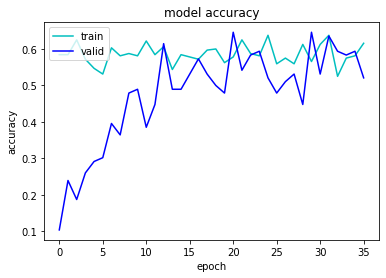

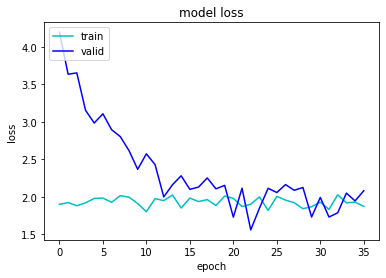

In [ ]:
model_B3_ru.compile(loss='categorical_crossentropy',
              optimizer=Adadelta(learning_rate=0.001), 
                metrics=["accuracy"])

start = time.time()

history_B3_ruadad = model_B3_ru.fit_generator(
      train_datagen,
      steps_per_epoch= np.ceil(400/batch_size),
      epochs=epochs,
      validation_data=test_datagen,
      validation_steps= np.ceil(100/batch_size),
      verbose=verbose,
      callbacks = [early_stopping_cd])
print('Execution time: ', time.time()-start)

# Summerize history for accuracy and loss
show_history(history_B3_ruadad)

### RMSprop

In [ ]:
model_B3_ru.compile(loss='categorical_crossentropy',
              optimizer=RMSprop(lr=2e-5),
              metrics=['accuracy'])

start = time.time()

history_B3_rurms = model_B3_ru.fit_generator(
      train_datagen,
      steps_per_epoch= np.ceil(400/batch_size),
      epochs=epochs,
      validation_data=test_datagen,
      validation_steps= np.ceil(100/batch_size),
      verbose=verbose,
      callbacks = [early_stopping_cd])
print('Execution time: ', time.time()-start)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/60
10/10 [==============================] - 30s 1s/step - loss: 1.7757 - accuracy: 0.6266 - val_loss: 2.4646 - val_accuracy: 0.4271
Epoch 2/60
10/10 [==============================] - 9s 850ms/step - loss: 1.8454 - accuracy: 0.6111 - val_loss: 2.0337 - val_accuracy: 0.5312
Epoch 3/60
10/10 [==============================] - 8s 834ms/step - loss: 1.7571 - accuracy: 0.6043 - val_loss: 2.3058 - val_accuracy: 0.4688
Epoch 4/60
10/10 [==============================] - 8s 847ms/step - loss: 1.6697 - accuracy: 0.6275 - val_loss: 2.3649 - val_accuracy: 0.4583
Epoch 5/60
10/10 [==============================] - 9s 852ms/step - loss: 1.6263 - accuracy: 0.6962 - val_loss: 2.2384 - val_accuracy: 0.4688
Epoch 6/60
10/10 [==============================] - 9s 847ms/step - loss: 1.7094 - accuracy: 0.6268 - val_loss: 2.0753 - val_accuracy: 0.4583
Epoch 7/60
10/10 [==============================] - 9s 850ms/step - loss: 1.6200 - accuracy: 0.6463 - val_loss: 1.9831 - val_accuracy: 0.5208
Epoch 8/

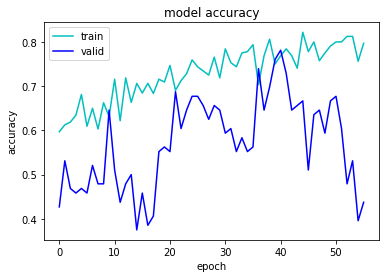

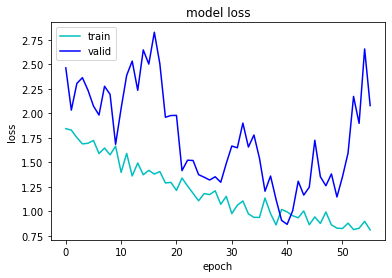

In [ ]:
# Summerize history for accuracy and loss
show_history(history_B3_rurms)

## EfficientNetB4

### Adam

In [ ]:
model_B4_ru.compile(loss="categorical_crossentropy", 
                optimizer=Adam(learning_rate=0.0001), 
                metrics=["accuracy"])

start = time.time()

history_B4_ruadam = model_B4_ru.fit_generator(
      train_datagen,
      steps_per_epoch= np.ceil(400/batch_size),
      epochs=epochs,
      validation_data=test_datagen,
      validation_steps= np.ceil(100/batch_size),
      verbose=verbose,
      callbacks = [reducelr])
print('Execution time: ', time.time()-start)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/80
10/10 [==============================] - 30s 1s/step - loss: 5.2978 - accuracy: 0.0102 - val_loss: 4.7955 - val_accuracy: 0.0104
Epoch 2/80
10/10 [==============================] - 12s 1s/step - loss: 5.1089 - accuracy: 0.0152 - val_loss: 4.8023 - val_accuracy: 0.0000e+00
Epoch 3/80
10/10 [==============================] - 12s 1s/step - loss: 4.7696 - accuracy: 0.0428 - val_loss: 4.8314 - val_accuracy: 0.0000e+00
Epoch 4/80
10/10 [==============================] - 12s 1s/step - loss: 4.4798 - accuracy: 0.1215 - val_loss: 4.7964 - val_accuracy: 0.0000e+00
Epoch 5/80
10/10 [==============================] - 11s 1s/step - loss: 4.1954 - accuracy: 0.1218 - val_loss: 4.7986 - val_accuracy: 0.0104
Epoch 6/80
10/10 [==============================] - 12s 1s/step - loss: 4.2476 - accuracy: 0.1053 - val_loss: 4.8215 - val_accuracy: 0.0104
Epoch 7/80
10/10 [==============================] - 11s 1s/step - loss: 3.4521 - accuracy: 0.2685 - val_loss: 4.8011 - val_accuracy: 0.0000e+00
Epoc

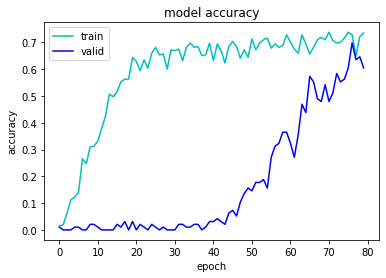

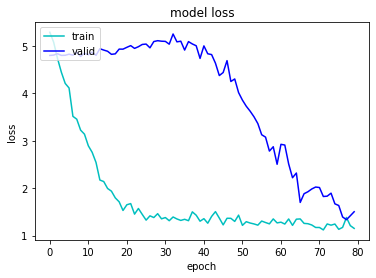

In [ ]:
# Summerize history for accuracy and loss
show_history(history_B4_ruadam)

### Adadelta

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/60
10/10 [==============================] - 27s 1s/step - loss: 4.3218 - accuracy: 0.0979 - val_loss: 5.1493 - val_accuracy: 0.0000e+00
Epoch 2/60
10/10 [==============================] - 11s 1s/step - loss: 4.1299 - accuracy: 0.1147 - val_loss: 5.0866 - val_accuracy: 0.0000e+00
Epoch 3/60
10/10 [==============================] - 11s 1s/step - loss: 4.3059 - accuracy: 0.0790 - val_loss: 5.1402 - val_accuracy: 0.0000e+00
Epoch 4/60
10/10 [==============================] - 11s 1s/step - loss: 4.1578 - accuracy: 0.1214 - val_loss: 5.0713 - val_accuracy: 0.0208
Epoch 5/60
10/10 [==============================] - 11s 1s/step - loss: 4.2452 - accuracy: 0.1312 - val_loss: 4.9793 - val_accuracy: 0.0104
Epoch 6/60
10/10 [==============================] - 11s 1s/step - loss: 4.2674 - accuracy: 0.0835 - val_loss: 5.0699 - val_accuracy: 0.0104
Epoch 7/60
10/10 [==============================] - 11s 1s/step - loss: 4.1347 - accuracy: 0.1109 - val_loss: 5.2301 - val_accuracy: 0.0000e+00
Epoc

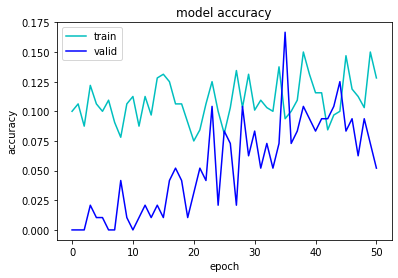

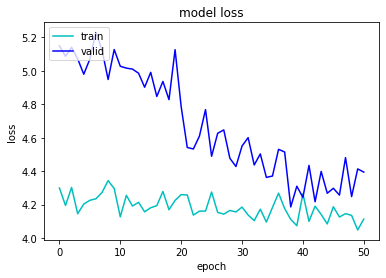

In [ ]:
model_B4_ru.compile(loss='categorical_crossentropy',
              optimizer=Adadelta(learning_rate=0.001), 
                metrics=["accuracy"])

start = time.time()

history_B4_ruadad = model_B4_ru.fit_generator(
      train_datagen,
      steps_per_epoch= np.ceil(400/batch_size),
      epochs=epochs,
      validation_data=test_datagen,
      validation_steps= np.ceil(100/batch_size),
      verbose=verbose,
      callbacks = [early_stopping_cd])
print('Execution time: ', time.time()-start)

# Summerize history for accuracy and loss
show_history(history_B4_ruadad)

### RMSprop

In [ ]:
model_B4_ru.compile(loss='categorical_crossentropy',
              optimizer=RMSprop(lr=2e-5),
              metrics=['accuracy'])

start = time.time()

history_B4_rurms = model_B4_ru.fit_generator(
      train_datagen,
      steps_per_epoch= np.ceil(400/batch_size),
      epochs=epochs,
      validation_data=test_datagen,
      validation_steps= np.ceil(100/batch_size),
      verbose=verbose,
      callbacks = [early_stopping_cd])
print('Execution time: ', time.time()-start)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/60
10/10 [==============================] - 37s 1s/step - loss: 4.1012 - accuracy: 0.1119 - val_loss: 4.5665 - val_accuracy: 0.0625
Epoch 2/60
10/10 [==============================] - 11s 1s/step - loss: 4.0263 - accuracy: 0.1265 - val_loss: 4.5354 - val_accuracy: 0.0833
Epoch 3/60
10/10 [==============================] - 11s 1s/step - loss: 3.9461 - accuracy: 0.1429 - val_loss: 4.5517 - val_accuracy: 0.0729
Epoch 4/60
10/10 [==============================] - 11s 1s/step - loss: 3.7349 - accuracy: 0.1737 - val_loss: 4.1282 - val_accuracy: 0.0938
Epoch 5/60
10/10 [==============================] - 11s 1s/step - loss: 3.7390 - accuracy: 0.1539 - val_loss: 4.1844 - val_accuracy: 0.1458
Epoch 6/60
10/10 [==============================] - 11s 1s/step - loss: 3.7357 - accuracy: 0.1970 - val_loss: 4.0408 - val_accuracy: 0.1667
Epoch 7/60
10/10 [==============================] - 11s 1s/step - loss: 3.8403 - accuracy: 0.1583 - val_loss: 3.7958 - val_accuracy: 0.1354
Epoch 8/60
10/10 [==

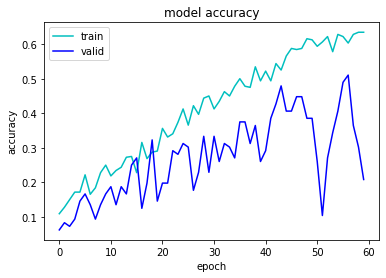

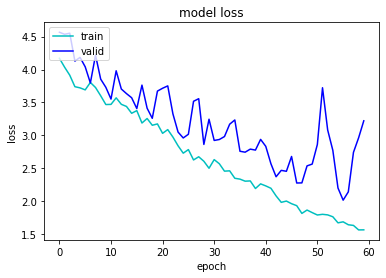

In [ ]:
# Summerize history for accuracy and loss
show_history(history_B4_rurms)

# 5 classes

In [ ]:
epochs = 40
batch_size = 40

### RMSprop - B0

In [ ]:
model_B0_ru.compile(loss='categorical_crossentropy',
              optimizer=RMSprop(lr=2e-5),
              metrics=['accuracy'])

start = time.time()

history_B0_ru = model_B0_ru.fit(
      X5_train,
      steps_per_epoch= np.ceil(400/batch_size),
      epochs=epochs,
      validation_data=X5_test,
      validation_steps= np.ceil(100/batch_size),
      verbose=verbose,
      use_multiprocessing=False,
      workers=4)
print('Execution time: ', time.time()-start)

Epoch 1/40


InvalidArgumentError: ignored

In [ ]:
# Summerize history for accuracy and loss
show_history(history_B0_ru)

### RMSprop - B1

In [ ]:
model_B1_ru.compile(loss='categorical_crossentropy',
              optimizer=RMSprop(lr=2e-5),
              metrics=['accuracy'])

start = time.time()

history_B1_ru = model_B1_ru.fit_generator(
      X5_train,
      steps_per_epoch= np.ceil(400/batch_size),
      epochs=epochs,
      validation_data=X5_test,
      validation_steps= np.ceil(100/batch_size),
      verbose=1,
      use_multiprocessing=False,
      workers=4)
print('Execution time: ', time.time()-start)

In [ ]:
# Summerize history for accuracy and loss
show_history(history_B0_ru)

# Learning rate

In [ ]:
epochs = 100
batch_size=40
verbose = 1

In [ ]:
learning_rate = 0.01
#learning_rate = 0.001
#learning_rate = 0.0001
#learning_rate = 1e-6

## EfficientNetB3

### Adadelta

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/100
10/10 [==============================] - 49s 4s/step - loss: 13.5472 - accuracy: 0.0027 - val_loss: 241499226112.0000 - val_accuracy: 0.0000e+00
Epoch 2/100
10/10 [==============================] - 36s 4s/step - loss: 13.6023 - accuracy: 0.0055 - val_loss: 627849152.0000 - val_accuracy: 0.0104
Epoch 3/100
10/10 [==============================] - 33s 3s/step - loss: 13.6782 - accuracy: 0.0058 - val_loss: 18510236.0000 - val_accuracy: 0.0104
Epoch 4/100
10/10 [==============================] - 31s 3s/step - loss: 14.2450 - accuracy: 0.0116 - val_loss: 357876.0000 - val_accuracy: 0.0000e+00
Epoch 5/100
10/10 [==============================] - 30s 3s/step - loss: 14.3691 - accuracy: 0.0048 - val_loss: 40188.5469 - val_accuracy: 0.0104
Epoch 6/100
10/10 [==============================] - 32s 3s/step - loss: 13.0910 - accuracy: 0.0033 - val_loss: 12385.6094 - val_accuracy: 0.0000e+00
Epoch 7/100
10/10 [==============================] - 33s 3s/step - loss: 13.6402 - accuracy: 0.00

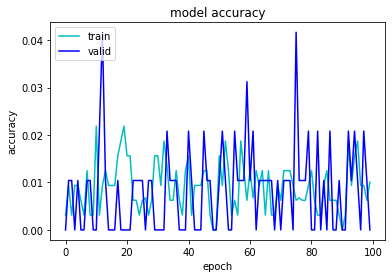

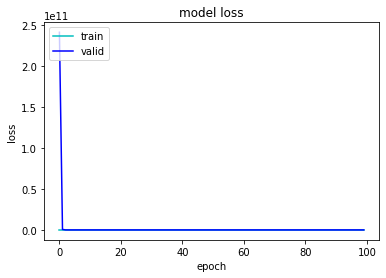

In [ ]:
model_B3_ru.compile(loss='categorical_crossentropy',
              optimizer=Adadelta(learning_rate=learning_rate), 
                metrics=["accuracy"])

start = time.time()

history_B3_ruadad = model_B3_ru.fit_generator(
      train_datagen,
      steps_per_epoch= np.ceil(400/batch_size),
      epochs=epochs,
      validation_data=test_datagen,
      validation_steps= np.ceil(100/batch_size),
      verbose=1,
      callbacks = [reducelr])
print('Execution time: ', time.time()-start)

# Summerize history for accuracy and loss
show_history(history_B3_ruadad)

### RMSprop

In [ ]:
model_B3_ru.compile(loss='categorical_crossentropy',
              optimizer=RMSprop(lr=learning_rate),
              metrics=['accuracy'])

start = time.time()

history_B3_rurms = model_B3_ru.fit_generator(
      train_datagen,
      steps_per_epoch= np.ceil(400/batch_size),
      epochs=epochs,
      validation_data=test_datagen,
      validation_steps= np.ceil(100/batch_size),
      verbose=1,
      callbacks = [reducelr])
print('Execution time: ', time.time()-start)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/100
10/10 [==============================] - 29s 1s/step - loss: 16.6297 - accuracy: 0.0018 - val_loss: 469690646528.0000 - val_accuracy: 0.0000e+00
Epoch 2/100
10/10 [==============================] - 9s 849ms/step - loss: 17.8379 - accuracy: 0.0049 - val_loss: 9476105216.0000 - val_accuracy: 0.0312
Epoch 3/100
10/10 [==============================] - 9s 857ms/step - loss: 11.4480 - accuracy: 0.0056 - val_loss: 4114504960.0000 - val_accuracy: 0.0000e+00
Epoch 4/100
10/10 [==============================] - 9s 859ms/step - loss: 11.2974 - accuracy: 0.0104 - val_loss: 25496504.0000 - val_accuracy: 0.0208
Epoch 5/100
10/10 [==============================] - 9s 868ms/step - loss: 9.3030 - accuracy: 0.0129 - val_loss: 75395000.0000 - val_accuracy: 0.0000e+00
Epoch 6/100
10/10 [==============================] - 8s 845ms/step - loss: 9.1575 - accuracy: 0.0040 - val_loss: 868871.3125 - val_accuracy: 0.0000e+00
Epoch 7/100
10/10 [==============================] - 9s 848ms/step - loss: 9

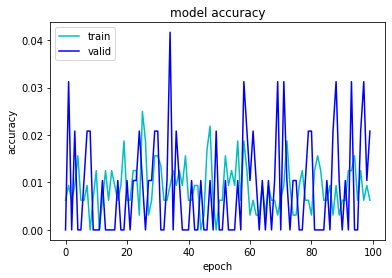

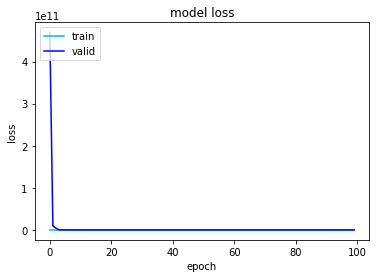

In [ ]:
# Summerize history for accuracy and loss
show_history(history_B3_rurms)

## EfficientNetB4

### Adadelta

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/100
10/10 [==============================] - 29s 1s/step - loss: 5.2162 - accuracy: 0.0115 - val_loss: 4.8043 - val_accuracy: 0.0208
Epoch 2/100
10/10 [==============================] - 12s 1s/step - loss: 5.2760 - accuracy: 0.0110 - val_loss: 4.7940 - val_accuracy: 0.0208
Epoch 3/100
10/10 [==============================] - 11s 1s/step - loss: 5.1783 - accuracy: 0.0034 - val_loss: 4.8257 - val_accuracy: 0.0000e+00
Epoch 4/100
10/10 [==============================] - 11s 1s/step - loss: 5.1891 - accuracy: 0.0141 - val_loss: 4.7923 - val_accuracy: 0.0000e+00
Epoch 5/100
10/10 [==============================] - 11s 1s/step - loss: 5.1980 - accuracy: 0.0223 - val_loss: 4.7950 - val_accuracy: 0.0104
Epoch 6/100
10/10 [==============================] - 11s 1s/step - loss: 5.0396 - accuracy: 0.0077 - val_loss: 4.8389 - val_accuracy: 0.0000e+00
Epoch 7/100
10/10 [==============================] - 11s 1s/step - loss: 5.0352 - accuracy: 0.0205 - val_loss: 4.7963 - val_accuracy: 0.0000e+

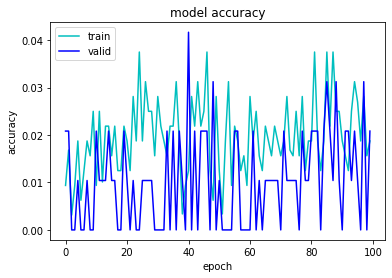

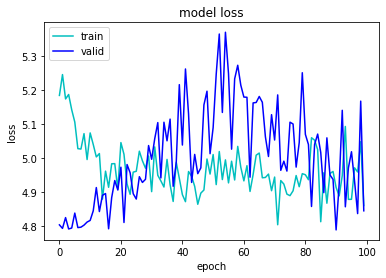

In [ ]:
model_B4_ru.compile(loss='categorical_crossentropy',
              optimizer=Adadelta(learning_rate=learning_rate), 
                metrics=["accuracy"])

start = time.time()

history_B4_ruadad = model_B4_ru.fit_generator(
      train_datagen,
      steps_per_epoch= np.ceil(400/batch_size),
      epochs=epochs,
      validation_data=test_datagen,
      validation_steps= np.ceil(100/batch_size),
      verbose=verbose,
      callbacks = [reducelr])
print('Execution time: ', time.time()-start)

# Summerize history for accuracy and loss
show_history(history_B4_ruadad)

### RMSprop

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/100
10/10 [==============================] - 35s 1s/step - loss: 12.9657 - accuracy: 0.0172 - val_loss: 17456655437805852672655360.0000 - val_accuracy: 0.0208
Epoch 2/100
10/10 [==============================] - 11s 1s/step - loss: 12.1177 - accuracy: 0.0071 - val_loss: 420057042284324480614400.0000 - val_accuracy: 0.0104
Epoch 3/100
10/10 [==============================] - 11s 1s/step - loss: 11.1872 - accuracy: 0.0135 - val_loss: 1779203327788056576.0000 - val_accuracy: 0.0104
Epoch 4/100
10/10 [==============================] - 11s 1s/step - loss: 10.4148 - accuracy: 0.0052 - val_loss: 85626539999232.0000 - val_accuracy: 0.0000e+00
Epoch 5/100
10/10 [==============================] - 11s 1s/step - loss: 10.0838 - accuracy: 0.0124 - val_loss: 519752810496.0000 - val_accuracy: 0.0104
Epoch 6/100
10/10 [==============================] - 11s 1s/step - loss: 9.5932 - accuracy: 0.0101 - val_loss: 1050700864.0000 - val_accuracy: 0.0312
Epoch 7/100
10/10 [===========================

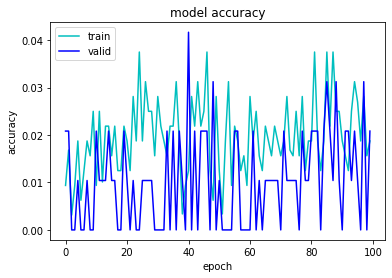

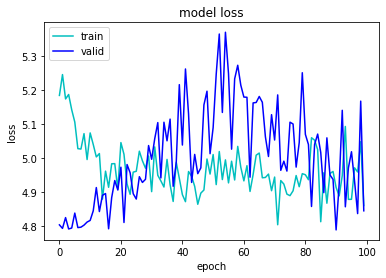

In [ ]:
model_B4_ru.compile(loss='categorical_crossentropy',
              optimizer=RMSprop(lr=learning_rate),
              metrics=['accuracy'])

start = time.time()

history_B4_rurms = model_B4_ru.fit_generator(
      train_datagen,
      steps_per_epoch= np.ceil(400/batch_size),
      epochs=epochs,
      validation_data=test_datagen,
      validation_steps= np.ceil(100/batch_size),
      verbose=1,
      callbacks = [reducelr])
print('Execution time: ', time.time()-start)

# Summerize history for accuracy and loss
show_history(history_B4_ruadad)

# Kaggle VarianceScaling

## EfficientNetB3

Optimizer: Adam \
Learning rate: 0,0001 \
Callbacks: Reducelr \


### EP=80 & BS = 40

In [19]:
epochs = 80
batch_size = 40

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/80
10/10 [==============================] - 78s 7s/step - loss: 2.1902 - accuracy: 0.6342 - val_loss: 4.7517 - val_accuracy: 0.0104
Epoch 2/80
10/10 [==============================] - 62s 6s/step - loss: 2.1013 - accuracy: 0.6214 - val_loss: 4.8172 - val_accuracy: 0.0104
Epoch 3/80
10/10 [==============================] - 63s 6s/step - loss: 2.0386 - accuracy: 0.6080 - val_loss: 4.7754 - val_accuracy: 0.0312
Epoch 4/80
10/10 [==============================] - 60s 6s/step - loss: 1.9146 - accuracy: 0.6030 - val_loss: 4.8039 - val_accuracy: 0.0312
Epoch 5/80
10/10 [==============================] - 56s 6s/step - loss: 1.6050 - accuracy: 0.6683 - val_loss: 4.8474 - val_accuracy: 0.0000e+00
Epoch 6/80
10/10 [==============================] - 51s 5s/step - loss: 1.5532 - accuracy: 0.7153 - val_loss: 4.8425 - val_accuracy: 0.0000e+00
Epoch 7/80
10/10 [==============================] - 52s 5s/step - loss: 1.4712 - accuracy: 0.7549 - val_loss: 4.8486 - val_accuracy: 0.0000e+00
Epoch 8/

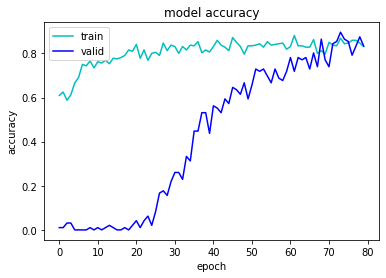

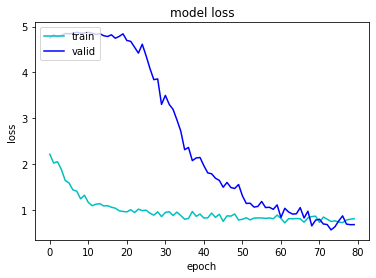

In [21]:
model_B3_vs.compile(loss="categorical_crossentropy", 
                optimizer=Adam(learning_rate=0.0001), 
                metrics=["accuracy"])

start = time.time()

history_B3_vsadam = model_B3_vs.fit_generator(
      train_datagen,
      steps_per_epoch= np.ceil(400/batch_size),
      epochs=epochs,
      validation_data=test_datagen,
      validation_steps= np.ceil(100/batch_size),
      verbose=verbose,
      callbacks = [reducelr, checkpoint_cb_best])
print('Execution time: ', time.time()-start)

# Summerize history for accuracy and loss
show_history(history_B3_vsadam)

In [22]:
print('Résultat: ', model_B3_vs.evaluate(test_datagen_final))

269/269 [==============================] - 2186s 8s/step - loss: 0.7371 - accuracy: 0.8241
Résultat:  [0.7371186017990112, 0.824077308177948]


In [78]:
model_B3_vs.save('model_B3_b40.h5')

### EP=100 & BS = 80

In [70]:
epochs = 100
batch_size = 80

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/100
5/5 [==============================] - 18s 1s/step - loss: 0.1898 - accuracy: 0.9501 - val_loss: 0.9961 - val_accuracy: 0.6719
Epoch 2/100
5/5 [==============================] - 4s 870ms/step - loss: 0.0932 - accuracy: 0.9851 - val_loss: 1.6232 - val_accuracy: 0.6094
Epoch 3/100
5/5 [==============================] - 5s 914ms/step - loss: 0.2260 - accuracy: 0.9334 - val_loss: 1.4959 - val_accuracy: 0.5781
Epoch 4/100
5/5 [==============================] - 4s 868ms/step - loss: 0.0949 - accuracy: 0.9708 - val_loss: 1.5421 - val_accuracy: 0.5469
Epoch 5/100
5/5 [==============================] - 4s 885ms/step - loss: 0.1429 - accuracy: 0.9568 - val_loss: 1.8963 - val_accuracy: 0.5938
Epoch 6/100
5/5 [==============================] - 4s 878ms/step - loss: 0.1653 - accuracy: 0.9543 - val_loss: 1.4171 - val_accuracy: 0.6250
Epoch 7/100
5/5 [==============================] - 4s 873ms/step - loss: 0.1207 - accuracy: 0.9682 - val_loss: 2.1390 - val_accuracy: 0.5000
Epoch 8/100
5/5

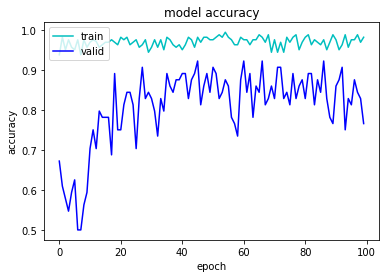

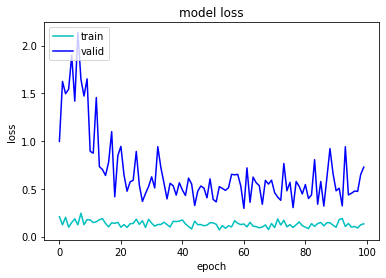

In [72]:
model_B3_vs.compile(loss="categorical_crossentropy", 
                optimizer=Adam(learning_rate=0.0001), 
                metrics=["accuracy"])

start = time.time()

history_B3_vsadad = model_B3_vs.fit_generator(
      train_datagen,
      steps_per_epoch= np.ceil(400/batch_size),
      epochs=epochs,
      validation_data=test_datagen,
      validation_steps= np.ceil(100/batch_size),
      verbose=verbose,
      callbacks = [reducelr, checkpoint_cb_best])
print('Execution time: ', time.time()-start)

# Summerize history for accuracy and loss
show_history(history_B3_vsadad)

In [73]:
print('Résultat: ', model_B3_vs.evaluate(test_datagen_final))

269/269 [==============================] - 41s 152ms/step - loss: 0.5013 - accuracy: 0.8537
Résultat:  [0.5013050436973572, 0.8536500334739685]


In [74]:
model_B3_vs.save('model_B3_e80.h5')

## EfficientNEtB4

Optimizer: Adam \
Learning rate: 0,0001 \
Callbacks: Reducelr \

### EP=80 & BS = 40

In [79]:
epochs = 80
batch_size = 40

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/80
10/10 [==============================] - 27s 1s/step - loss: 1.6021 - accuracy: 0.6977 - val_loss: 2.6480 - val_accuracy: 0.3854
Epoch 2/80
10/10 [==============================] - 9s 938ms/step - loss: 1.5255 - accuracy: 0.7327 - val_loss: 3.1186 - val_accuracy: 0.2917
Epoch 3/80
10/10 [==============================] - 10s 1s/step - loss: 1.4734 - accuracy: 0.6911 - val_loss: 3.2605 - val_accuracy: 0.1979
Epoch 4/80
10/10 [==============================] - 10s 1s/step - loss: 1.4866 - accuracy: 0.6864 - val_loss: 4.1486 - val_accuracy: 0.1146
Epoch 5/80
10/10 [==============================] - 10s 1s/step - loss: 1.4275 - accuracy: 0.7172 - val_loss: 4.5572 - val_accuracy: 0.0417
Epoch 6/80
10/10 [==============================] - 10s 943ms/step - loss: 1.1565 - accuracy: 0.7718 - val_loss: 4.4588 - val_accuracy: 0.0521
Epoch 7/80
10/10 [==============================] - 10s 1s/step - loss: 1.2038 - accuracy: 0.7520 - val_loss: 4.7652 - val_accuracy: 0.0000e+00
Epoch 8/80


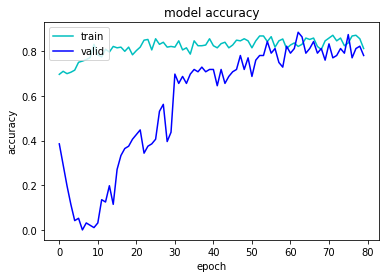

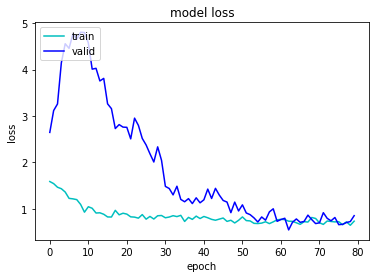

In [80]:
model_B4_vs.compile(loss="categorical_crossentropy", 
                optimizer=Adam(learning_rate=0.0001), 
                metrics=["accuracy"])

start = time.time()

history_B4_vsadaM = model_B4_vs.fit_generator(
      train_datagen,
      steps_per_epoch= np.ceil(400/batch_size),
      epochs=epochs,
      validation_data=test_datagen,
      validation_steps= np.ceil(100/batch_size),
      verbose=verbose,
      callbacks = [reducelr, checkpoint_cb_best])
print('Execution time: ', time.time()-start)

# Summerize history for accuracy and loss
show_history(history_B4_vsadaM)

In [81]:
print('Résultat: ', model_B4_vs.evaluate(test_datagen_final))

269/269 [==============================] - 51s 189ms/step - loss: 0.7220 - accuracy: 0.8212
Résultat:  [0.7219782471656799, 0.8211666345596313]


In [82]:
model_B4_vs.save('model_B4_b40.h5')

### EP=80 & BS = 80

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/80
5/5 [==============================] - 24s 2s/step - loss: 0.8315 - accuracy: 0.8017 - val_loss: 1.7523 - val_accuracy: 0.5781
Epoch 2/80
5/5 [==============================] - 5s 1s/step - loss: 0.8764 - accuracy: 0.7628 - val_loss: 2.4535 - val_accuracy: 0.4062
Epoch 3/80
5/5 [==============================] - 5s 1s/step - loss: 0.8305 - accuracy: 0.7547 - val_loss: 2.3094 - val_accuracy: 0.4375
Epoch 4/80
5/5 [==============================] - 5s 1s/step - loss: 0.7947 - accuracy: 0.7831 - val_loss: 2.0397 - val_accuracy: 0.4219
Epoch 5/80
5/5 [==============================] - 5s 1s/step - loss: 0.7345 - accuracy: 0.8051 - val_loss: 1.8528 - val_accuracy: 0.5469
Epoch 6/80
5/5 [==============================] - 5s 1s/step - loss: 0.7051 - accuracy: 0.8469 - val_loss: 1.4712 - val_accuracy: 0.6094
Epoch 7/80
5/5 [==============================] - 5s 1s/step - loss: 0.5434 - accuracy: 0.9114 - val_loss: 1.0004 - val_accuracy: 0.6719
Epoch 8/80
5/5 [========================

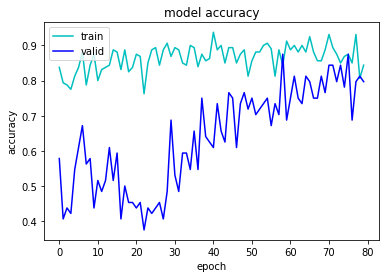

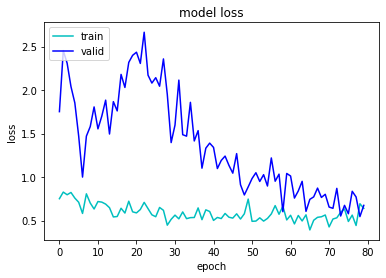

In [83]:
epochs = 80
batch_size = 80
model_B4_vs.compile(loss="categorical_crossentropy", 
                optimizer=Adam(learning_rate=0.0001), 
                metrics=["accuracy"])

start = time.time()

history_B4_vsadad = model_B4_vs.fit_generator(
      train_datagen,
      steps_per_epoch= np.ceil(400/batch_size),
      epochs=epochs,
      validation_data=test_datagen,
      validation_steps= np.ceil(100/batch_size),
      verbose=verbose,
      callbacks = [reducelr, checkpoint_cb_best])
print('Execution time: ', time.time()-start)

# Summerize history for accuracy and loss
show_history(history_B4_vsadad)

In [84]:
print('Résultat: ', model_B4_vs.evaluate(test_datagen_final))

269/269 [==============================] - 51s 191ms/step - loss: 0.6364 - accuracy: 0.8270
Résultat:  [0.6364232897758484, 0.8269879817962646]


In [85]:
model_B4_vs.save('model_B4_b80.h5')

# Meilleur modèle sur données test

In [18]:
epochs = 80
batch_size = 40

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/80
10/10 [==============================] - 22s 1s/step - loss: 2.1865 - accuracy: 0.6023 - val_loss: 4.1679 - val_accuracy: 0.1458
Epoch 2/80
10/10 [==============================] - 9s 851ms/step - loss: 1.9992 - accuracy: 0.6562 - val_loss: 4.5346 - val_accuracy: 0.0938
Epoch 3/80
10/10 [==============================] - 9s 862ms/step - loss: 1.9254 - accuracy: 0.6455 - val_loss: 4.4027 - val_accuracy: 0.1042
Epoch 4/80
10/10 [==============================] - 9s 854ms/step - loss: 1.7556 - accuracy: 0.6876 - val_loss: 3.5444 - val_accuracy: 0.2083
Epoch 5/80
10/10 [==============================] - 8s 831ms/step - loss: 1.5663 - accuracy: 0.7100 - val_loss: 3.8143 - val_accuracy: 0.2917
Epoch 6/80
10/10 [==============================] - 9s 826ms/step - loss: 1.4629 - accuracy: 0.7397 - val_loss: 4.1430 - val_accuracy: 0.1354
Epoch 7/80
10/10 [==============================] - 8s 838ms/step - loss: 1.3853 - accuracy: 0.7398 - val_loss: 4.6057 - val_accuracy: 0.0312
Epoch 8/

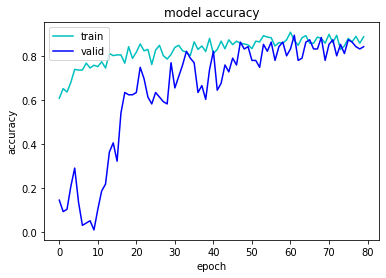

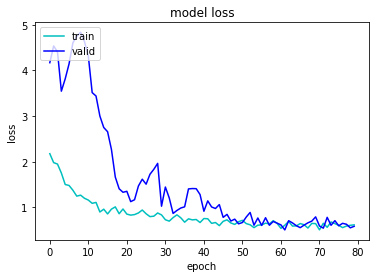

In [21]:
model_B3_vs.compile(loss="categorical_crossentropy", 
                optimizer=Adam(learning_rate=0.0001), 
                metrics=["accuracy"])

start = time.time()

history_B3_vsadam = model_B3_vs.fit_generator(
      train_datagen,
      steps_per_epoch= np.ceil(400/batch_size),
      epochs=epochs,
      validation_data=test_datagen,
      validation_steps= np.ceil(100/batch_size),
      verbose=verbose,
      callbacks = [reducelr, checkpoint_cb_best])
print('Execution time: ', time.time()-start)

# Summerize history for accuracy and loss
show_history(history_B3_vsadam)

In [20]:
print('Résultat: ', model_B3_vs.evaluate(test_datagen_final))

269/269 [==============================] - 2100s 8s/step - loss: 2.2252 - accuracy: 0.6404
Résultat:  [2.2252237796783447, 0.6403539180755615]


In [ ]:
model_B3_vs.save('best_effnet.h5')